In [1]:
import os
import gc
import json
import glob
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import seaborn as sns
import tqdm
import random

import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import PIL
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

In [2]:
# Бинарный поиск для приближения предсказанной маски 4-хугольником
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0., 1.

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print('simplify_contour didnt coverege')
            return None

        k = (lb + ub)/2.
        eps = k*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub)/2.
        elif len(approx) < n_corners:
            ub = (lb + ub)/2.
        else:
            return approx

# Отображаем 4-хугольник в прямоугольник 
# Спасибо ulebok за идею 
# И вот этим ребятам за реализацию: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

# Визуализируем детекцию (4 точки, bounding box и приближенный по маске контур)
def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None):
    img = Image.open(file)
    img_tensor = my_transforms(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    
    blackImg = np.zeros(image.shape, image.dtype)
    blackImg[:,:] = (0, 0, 0)
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        name = id_to_name[label]
        color = palette[label]
        
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:            
            crop_img = image[y_min:y_max, x_min:x_max]
            print('Bounding box:')
            show_image(crop_img, figsize=(10, 2))
            
            # В разных версиях opencv этот метод возвращает разное число параметров
            contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
#             _,contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
#                 points = [[x_min, y_min], [x_min, y_max], [x_max, y_min],[x_max, y_max]]
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]
            
            
            points = np.array(points)
            crop_mask_img = four_point_transform(img, points)
            print('Rotated img:')
            crop_mask_img = cv2.resize(crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA)
            show_image(crop_mask_img, figsize=(10, 2))
            if approx is not None:
                cv2.drawContours(image, [approx], 0, (255,0,255), 3)
            image = cv2.circle(image, (x0, y0), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x3, y3), radius=5, color=(0, 0, 255), thickness=-1)
            
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            
    show_image(image)
    return prediction

# Просто показать картинку. С семинара
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    

# Переводит предсказания модели в текст. С семинара
def decode(pred, alphabet):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], alphabet))
    return outputs

def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([alphabet[c] for c in out])
    return out
    

        
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
# Чтобы без проблем сериализовывать json. Без него есть нюансы
class npEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int32):
            return int(obj)
        return json.JSONEncoder.default(self, obj)

In [3]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

DEVICE_NUM = 0
device = torch.device(f'cuda:{DEVICE_NUM}') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
DATA_PATH = './data/'
TRAIN_SIZE = 0.8
BATCH_SIZE = 4
BATCH_SIZE_OCR = 16
DETECTOR_MODEL_PATH = f'detector{SEED}.pt'
OCR_MODEL_PATH = f'ocr{SEED}.pt'

all_marks = load_json(os.path.join(DATA_PATH, 'train.json'))
all_marks = [mark for mark in all_marks if mark['file'] != 'train/25632.bmp'] # странное изображение

# train_marks = np.random.choice(np.arange(len(all_marks)), size=int(TRAIN_SIZE * len(all_marks)), replace=False)
# val_marks = np.array(list(set(np.arange(len(all_marks))) - set(train_marks)))

# train_marks = list(np.array(all_marks)[train_marks])
# val_marks = list(np.array(all_marks)[val_marks])

train_marks = all_marks

# 1. Находим номера

### a) Модель для детекции

В задании есть данные о 4 точках, которые задают номер. Эти 4 точки - почти всегда не прямоугольник, а произвольный четырехугольник. Будем предсказывать:

- bounding box, который окружает точки (детекция)
- маску, заполненную тем, что внутри 4-х точек (сегментация)

Сначала обучим последние слои, затем разморозим и дообучим остальные.

In [5]:
def get_detector_model():
    
    model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        pretrained_backbone=True,
        progress=True, 
        num_classes=91, 
    )

    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.box_predictor = box_predictor
    
    mask_predictor = MaskRCNNPredictor(256, 256, num_classes)
    model.roi_heads.mask_predictor = mask_predictor

    # Заморозим все слои кроме последних
    
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.backbone.fpn.parameters():
        param.requires_grad = True

    for param in model.rpn.parameters():
        param.requires_grad = True

    for param in model.roi_heads.parameters():
        param.requires_grad = True
    
    return model

### b) Датасет для детекции

In [6]:
class DetectionDataset(Dataset):
    def __init__(self, marks, img_folder, transforms=None):
        
        self.marks = marks
        self.img_folder = img_folder
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = f'{self.img_folder}{item["file"]}'
        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        
        box_coords = item['nums']
        boxes = []
        labels = []
        masks = []
        for box in box_coords:
            points = np.array(box['box'])  
            x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
            x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])
            boxes.append([x0, y0, x2, y2])
            labels.append(1)
            
            # Здесь мы наши 4 точки превращаем в маску
            # Это нужно, чтобы кроме bounding box предсказывать и, соответственно, маску :)
            nx, ny = w, h
            poly_verts = points
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny,nx)).astype(int)
            masks.append(grid)
            
        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)
        masks = torch.as_tensor(masks)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
        }
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    
    def __len__(self):
        return len(self.marks)
    
my_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = DetectionDataset(
    marks=train_marks, 
    img_folder='data/', 
    transforms=my_transforms
)
# val_dataset = DetectionDataset(
#     marks=val_marks, 
#     img_folder='data/', 
#     transforms=my_transforms
# )

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=True,
    num_workers=4,
    collate_fn=collate_fn, 
)

# val_loader = DataLoader(
#     val_dataset, 
#     batch_size=BATCH_SIZE, 
#     drop_last=False,
#     num_workers=4,
#     collate_fn=collate_fn, 
# )

### c) Обучаем модель для детекции

In [49]:
torch.cuda.empty_cache()
gc.collect()
model = get_detector_model()
# model.load_state_dict(torch.load(DETECTOR_MODEL_PATH))
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequentia

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

model.train()
for epoch in range(1):

    print_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 

  0%|          | 0/6408 [00:00<?, ?it/s]/home/n.beznosov/.local/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
  0%|          | 20/6408 [00:13<1:06:39,  1.60it/s]

Loss: 0.8203255


  1%|          | 40/6408 [00:26<1:07:21,  1.58it/s]

Loss: 0.3335308


  1%|          | 60/6408 [00:40<1:07:38,  1.56it/s]

Loss: 0.3161376


  1%|          | 80/6408 [00:52<1:05:28,  1.61it/s]

Loss: 0.2745051


  2%|▏         | 100/6408 [01:05<1:08:36,  1.53it/s]

Loss: 0.2347327


  2%|▏         | 120/6408 [01:19<1:11:26,  1.47it/s]

Loss: 0.1957226


  2%|▏         | 140/6408 [01:31<1:04:36,  1.62it/s]

Loss: 0.2246734


  2%|▏         | 160/6408 [01:44<1:06:16,  1.57it/s]

Loss: 0.1961418


  3%|▎         | 180/6408 [01:57<1:07:34,  1.54it/s]

Loss: 0.2065120


  3%|▎         | 200/6408 [02:10<1:06:59,  1.54it/s]

Loss: 0.1876640


  3%|▎         | 220/6408 [02:23<1:09:13,  1.49it/s]

Loss: 0.1921135


  4%|▎         | 240/6408 [02:36<1:07:22,  1.53it/s]

Loss: 0.2168931


  4%|▍         | 260/6408 [02:49<1:05:59,  1.55it/s]

Loss: 0.1986829


  4%|▍         | 280/6408 [03:02<1:05:28,  1.56it/s]

Loss: 0.1955175


  5%|▍         | 300/6408 [03:15<1:07:42,  1.50it/s]

Loss: 0.1866542


  5%|▍         | 320/6408 [03:28<1:03:45,  1.59it/s]

Loss: 0.1855378


  5%|▌         | 340/6408 [03:41<1:02:41,  1.61it/s]

Loss: 0.1762402


  6%|▌         | 360/6408 [03:54<1:04:39,  1.56it/s]

Loss: 0.1617301


  6%|▌         | 380/6408 [04:07<1:07:27,  1.49it/s]

Loss: 0.1849573


  6%|▌         | 400/6408 [04:20<1:06:38,  1.50it/s]

Loss: 0.1780093


  7%|▋         | 420/6408 [04:33<1:03:43,  1.57it/s]

Loss: 0.1812054


  7%|▋         | 440/6408 [04:46<1:05:16,  1.52it/s]

Loss: 0.1778997


  7%|▋         | 460/6408 [04:59<1:02:34,  1.58it/s]

Loss: 0.1654871


  7%|▋         | 480/6408 [05:12<1:06:00,  1.50it/s]

Loss: 0.2017006


  8%|▊         | 500/6408 [05:25<1:08:18,  1.44it/s]

Loss: 0.1739817


  8%|▊         | 520/6408 [05:39<1:06:24,  1.48it/s]

Loss: 0.1871160


  8%|▊         | 540/6408 [05:52<1:03:14,  1.55it/s]

Loss: 0.1682641


  9%|▊         | 560/6408 [06:05<1:01:23,  1.59it/s]

Loss: 0.1699759


  9%|▉         | 580/6408 [06:18<1:00:48,  1.60it/s]

Loss: 0.1780300


  9%|▉         | 600/6408 [06:31<1:05:05,  1.49it/s]

Loss: 0.1839939


 10%|▉         | 620/6408 [06:44<59:49,  1.61it/s]  

Loss: 0.1825119


 10%|▉         | 640/6408 [06:57<1:06:47,  1.44it/s]

Loss: 0.1637069


 10%|█         | 660/6408 [07:11<1:03:27,  1.51it/s]

Loss: 0.1818341


 11%|█         | 680/6408 [07:24<1:04:55,  1.47it/s]

Loss: 0.1777796


 11%|█         | 700/6408 [07:37<1:03:32,  1.50it/s]

Loss: 0.1679850


 11%|█         | 720/6408 [07:50<1:05:12,  1.45it/s]

Loss: 0.1824102


 12%|█▏        | 740/6408 [08:03<1:02:03,  1.52it/s]

Loss: 0.1735393


 12%|█▏        | 760/6408 [08:16<1:03:17,  1.49it/s]

Loss: 0.1594974


 12%|█▏        | 780/6408 [08:29<1:00:22,  1.55it/s]

Loss: 0.1892633


 12%|█▏        | 800/6408 [08:42<1:00:35,  1.54it/s]

Loss: 0.1636735


 13%|█▎        | 820/6408 [08:55<1:01:45,  1.51it/s]

Loss: 0.1589441


 13%|█▎        | 840/6408 [09:08<1:01:05,  1.52it/s]

Loss: 0.1744694


 13%|█▎        | 860/6408 [09:21<1:01:40,  1.50it/s]

Loss: 0.1756831


 14%|█▎        | 880/6408 [09:34<1:01:00,  1.51it/s]

Loss: 0.1992901


 14%|█▍        | 900/6408 [09:47<57:20,  1.60it/s]  

Loss: 0.1684854


 14%|█▍        | 920/6408 [10:00<1:01:08,  1.50it/s]

Loss: 0.1630147


 15%|█▍        | 940/6408 [10:14<1:02:08,  1.47it/s]

Loss: 0.1742743


 15%|█▍        | 960/6408 [10:27<1:02:04,  1.46it/s]

Loss: 0.1847545


 15%|█▌        | 980/6408 [10:40<1:05:25,  1.38it/s]

Loss: 0.1776234


 16%|█▌        | 1000/6408 [10:53<57:03,  1.58it/s] 

Loss: 0.1589615


 16%|█▌        | 1020/6408 [11:06<56:23,  1.59it/s]

Loss: 0.1504336


 16%|█▌        | 1040/6408 [11:19<1:01:24,  1.46it/s]

Loss: 0.1700714


 17%|█▋        | 1060/6408 [11:32<55:35,  1.60it/s]  

Loss: 0.1748947


 17%|█▋        | 1080/6408 [11:45<1:00:44,  1.46it/s]

Loss: 0.1586454


 17%|█▋        | 1100/6408 [11:59<58:58,  1.50it/s]  

Loss: 0.1675465


 17%|█▋        | 1120/6408 [12:12<1:00:11,  1.46it/s]

Loss: 0.1752737


 18%|█▊        | 1140/6408 [12:25<56:33,  1.55it/s]  

Loss: 0.1814140


 18%|█▊        | 1160/6408 [12:38<54:38,  1.60it/s]

Loss: 0.1732408


 18%|█▊        | 1180/6408 [12:51<56:27,  1.54it/s]  

Loss: 0.1957771


 19%|█▊        | 1200/6408 [13:04<53:47,  1.61it/s]

Loss: 0.1707801


 19%|█▉        | 1220/6408 [13:18<58:10,  1.49it/s]  

Loss: 0.1842724


 19%|█▉        | 1240/6408 [13:31<53:45,  1.60it/s]  

Loss: 0.1603944


 20%|█▉        | 1260/6408 [13:44<55:55,  1.53it/s]  

Loss: 0.1566719


 20%|█▉        | 1280/6408 [13:57<56:33,  1.51it/s]

Loss: 0.1703835


 20%|██        | 1300/6408 [14:11<56:46,  1.50it/s]  

Loss: 0.1823187


 21%|██        | 1320/6408 [14:23<53:40,  1.58it/s]

Loss: 0.1742935


 21%|██        | 1340/6408 [14:37<53:45,  1.57it/s]

Loss: 0.1637656


 21%|██        | 1360/6408 [14:49<54:23,  1.55it/s]

Loss: 0.1647115


 22%|██▏       | 1380/6408 [15:03<57:08,  1.47it/s]  

Loss: 0.1867642


 22%|██▏       | 1400/6408 [15:16<56:36,  1.47it/s]  

Loss: 0.1623606


 22%|██▏       | 1420/6408 [15:29<54:03,  1.54it/s]

Loss: 0.1616763


 22%|██▏       | 1440/6408 [15:42<56:31,  1.47it/s]

Loss: 0.1723282
Epoch    72: reducing learning rate of group 0 to 1.5000e-04.


 23%|██▎       | 1460/6408 [15:56<54:28,  1.51it/s]

Loss: 0.1643824


 23%|██▎       | 1480/6408 [16:09<54:28,  1.51it/s]  

Loss: 0.1669319


 23%|██▎       | 1500/6408 [16:22<55:10,  1.48it/s]

Loss: 0.1450030


 24%|██▎       | 1520/6408 [16:36<57:39,  1.41it/s]

Loss: 0.1701951


 24%|██▍       | 1540/6408 [16:49<53:22,  1.52it/s]

Loss: 0.1539853


 24%|██▍       | 1560/6408 [17:02<56:38,  1.43it/s]

Loss: 0.1559130


 25%|██▍       | 1580/6408 [17:16<53:43,  1.50it/s]

Loss: 0.1468053


 25%|██▍       | 1600/6408 [17:29<51:54,  1.54it/s]

Loss: 0.1526742


 25%|██▌       | 1620/6408 [17:42<52:01,  1.53it/s]

Loss: 0.1417484


 26%|██▌       | 1640/6408 [17:55<49:42,  1.60it/s]

Loss: 0.1441110


 26%|██▌       | 1660/6408 [18:09<55:19,  1.43it/s]  

Loss: 0.1573076


 26%|██▌       | 1680/6408 [18:22<52:03,  1.51it/s]

Loss: 0.1592482


 27%|██▋       | 1700/6408 [18:35<49:19,  1.59it/s]

Loss: 0.1424897


 27%|██▋       | 1720/6408 [18:48<50:08,  1.56it/s]

Loss: 0.1481852


 27%|██▋       | 1740/6408 [19:01<52:14,  1.49it/s]

Loss: 0.1481089


 27%|██▋       | 1760/6408 [19:14<47:30,  1.63it/s]

Loss: 0.1648029


 28%|██▊       | 1780/6408 [19:27<48:29,  1.59it/s]

Loss: 0.1548647


 28%|██▊       | 1800/6408 [19:41<52:15,  1.47it/s]

Loss: 0.1407774


 28%|██▊       | 1820/6408 [19:54<51:18,  1.49it/s]

Loss: 0.1497168


 29%|██▊       | 1840/6408 [20:07<48:12,  1.58it/s]

Loss: 0.1568099


 29%|██▉       | 1860/6408 [20:20<49:54,  1.52it/s]

Loss: 0.1579601


 29%|██▉       | 1880/6408 [20:34<49:10,  1.53it/s]

Loss: 0.1488110


 30%|██▉       | 1900/6408 [20:47<50:19,  1.49it/s]

Loss: 0.1649221


 30%|██▉       | 1920/6408 [21:00<48:10,  1.55it/s]

Loss: 0.1362818


 30%|███       | 1940/6408 [21:14<45:41,  1.63it/s]

Loss: 0.1483074


 31%|███       | 1960/6408 [21:27<47:53,  1.55it/s]

Loss: 0.1511575


 31%|███       | 1980/6408 [21:40<50:47,  1.45it/s]

Loss: 0.1839983


 31%|███       | 2000/6408 [21:53<48:12,  1.52it/s]

Loss: 0.1664352


 32%|███▏      | 2020/6408 [22:06<47:31,  1.54it/s]

Loss: 0.1580630


 32%|███▏      | 2040/6408 [22:19<48:28,  1.50it/s]

Loss: 0.1558300


 32%|███▏      | 2060/6408 [22:32<44:54,  1.61it/s]

Loss: 0.1397079


 32%|███▏      | 2080/6408 [22:45<48:07,  1.50it/s]

Loss: 0.1686519


 33%|███▎      | 2100/6408 [22:59<50:44,  1.41it/s]

Loss: 0.1384248


 33%|███▎      | 2120/6408 [23:12<47:29,  1.51it/s]

Loss: 0.1386785


 33%|███▎      | 2140/6408 [23:25<48:17,  1.47it/s]

Loss: 0.1431661


 34%|███▎      | 2160/6408 [23:38<46:00,  1.54it/s]

Loss: 0.1662222


 34%|███▍      | 2180/6408 [23:52<47:57,  1.47it/s]

Loss: 0.1450158


 34%|███▍      | 2200/6408 [24:05<46:08,  1.52it/s]

Loss: 0.1550971


 35%|███▍      | 2220/6408 [24:19<47:33,  1.47it/s]

Loss: 0.1634269


 35%|███▍      | 2240/6408 [24:32<47:25,  1.46it/s]

Loss: 0.1495568


 35%|███▌      | 2260/6408 [24:45<45:11,  1.53it/s]

Loss: 0.1541268


 36%|███▌      | 2280/6408 [24:58<46:11,  1.49it/s]

Loss: 0.1647892


 36%|███▌      | 2300/6408 [25:11<44:35,  1.54it/s]

Loss: 0.1591511


 36%|███▌      | 2320/6408 [25:25<46:38,  1.46it/s]

Loss: 0.1661740


 37%|███▋      | 2340/6408 [25:38<44:36,  1.52it/s]

Loss: 0.1479480
Epoch   117: reducing learning rate of group 0 to 7.5000e-05.


 37%|███▋      | 2360/6408 [25:51<43:47,  1.54it/s]

Loss: 0.1448532


 37%|███▋      | 2380/6408 [26:04<44:02,  1.52it/s]

Loss: 0.1612439


 37%|███▋      | 2400/6408 [26:17<43:39,  1.53it/s]

Loss: 0.1543087


 38%|███▊      | 2420/6408 [26:30<43:08,  1.54it/s]

Loss: 0.1470313


 38%|███▊      | 2440/6408 [26:43<41:28,  1.59it/s]

Loss: 0.1438029


 38%|███▊      | 2460/6408 [26:56<44:18,  1.49it/s]

Loss: 0.1439547


 39%|███▊      | 2480/6408 [27:10<44:14,  1.48it/s]

Loss: 0.1628350


 39%|███▉      | 2500/6408 [27:23<41:08,  1.58it/s]

Loss: 0.1759562


 39%|███▉      | 2520/6408 [27:36<43:56,  1.47it/s]

Loss: 0.1376600


 40%|███▉      | 2540/6408 [27:49<43:16,  1.49it/s]

Loss: 0.1494736


 40%|███▉      | 2560/6408 [28:03<44:17,  1.45it/s]

Loss: 0.1422718


 40%|████      | 2580/6408 [28:16<42:44,  1.49it/s]

Loss: 0.1746247


 41%|████      | 2600/6408 [28:29<41:00,  1.55it/s]

Loss: 0.1469717


 41%|████      | 2620/6408 [28:43<42:54,  1.47it/s]

Loss: 0.1612878


 41%|████      | 2640/6408 [28:56<41:31,  1.51it/s]

Loss: 0.1587303


 42%|████▏     | 2660/6408 [29:09<39:41,  1.57it/s]

Loss: 0.1797840


 42%|████▏     | 2680/6408 [29:22<39:51,  1.56it/s]

Loss: 0.1500709


 42%|████▏     | 2700/6408 [29:35<40:26,  1.53it/s]

Loss: 0.1342401


 42%|████▏     | 2720/6408 [29:48<39:47,  1.54it/s]

Loss: 0.1545019


 43%|████▎     | 2740/6408 [30:01<41:28,  1.47it/s]

Loss: 0.1585271


 43%|████▎     | 2760/6408 [30:14<40:05,  1.52it/s]

Loss: 0.1474624


 43%|████▎     | 2780/6408 [30:27<38:23,  1.57it/s]

Loss: 0.1446349


 44%|████▎     | 2800/6408 [30:41<40:51,  1.47it/s]

Loss: 0.1624847


 44%|████▍     | 2820/6408 [30:54<38:12,  1.57it/s]

Loss: 0.1486107


 44%|████▍     | 2840/6408 [31:08<41:09,  1.44it/s]

Loss: 0.1614482


 45%|████▍     | 2860/6408 [31:21<39:17,  1.50it/s]

Loss: 0.1288257


 45%|████▍     | 2880/6408 [31:34<37:40,  1.56it/s]

Loss: 0.1418349


 45%|████▌     | 2900/6408 [31:47<38:18,  1.53it/s]

Loss: 0.1556261


 46%|████▌     | 2920/6408 [32:00<38:41,  1.50it/s]

Loss: 0.1419084


 46%|████▌     | 2940/6408 [32:14<38:25,  1.50it/s]

Loss: 0.1477771


 46%|████▌     | 2960/6408 [32:27<38:16,  1.50it/s]

Loss: 0.1562761


 47%|████▋     | 2980/6408 [32:41<38:49,  1.47it/s]

Loss: 0.1518859


 47%|████▋     | 3000/6408 [32:54<37:35,  1.51it/s]

Loss: 0.1427304


 47%|████▋     | 3020/6408 [33:07<38:21,  1.47it/s]

Loss: 0.1395674


 47%|████▋     | 3040/6408 [33:20<37:41,  1.49it/s]

Loss: 0.1428985


 48%|████▊     | 3060/6408 [33:34<40:31,  1.38it/s]

Loss: 0.1331545


 48%|████▊     | 3080/6408 [33:47<37:00,  1.50it/s]

Loss: 0.1426203


 48%|████▊     | 3100/6408 [34:01<38:30,  1.43it/s]

Loss: 0.1446932


 49%|████▊     | 3120/6408 [34:14<35:23,  1.55it/s]

Loss: 0.1453870


 49%|████▉     | 3140/6408 [34:26<34:59,  1.56it/s]

Loss: 0.1449260


 49%|████▉     | 3160/6408 [34:39<34:36,  1.56it/s]

Loss: 0.1467149


 50%|████▉     | 3180/6408 [34:52<34:02,  1.58it/s]

Loss: 0.1529936


 50%|████▉     | 3200/6408 [35:06<36:08,  1.48it/s]

Loss: 0.1352904


 50%|█████     | 3220/6408 [35:19<35:11,  1.51it/s]

Loss: 0.1320776


 51%|█████     | 3240/6408 [35:32<37:57,  1.39it/s]

Loss: 0.1541250


 51%|█████     | 3260/6408 [35:46<35:33,  1.48it/s]

Loss: 0.1440448


 51%|█████     | 3280/6408 [35:59<34:20,  1.52it/s]

Loss: 0.1262504


 51%|█████▏    | 3300/6408 [36:12<33:30,  1.55it/s]

Loss: 0.1467095


 52%|█████▏    | 3320/6408 [36:25<34:54,  1.47it/s]

Loss: 0.1341564


 52%|█████▏    | 3340/6408 [36:38<32:43,  1.56it/s]

Loss: 0.1508864


 52%|█████▏    | 3360/6408 [36:51<31:21,  1.62it/s]

Loss: 0.1418924


 53%|█████▎    | 3380/6408 [37:05<33:58,  1.49it/s]

Loss: 0.1529876


 53%|█████▎    | 3400/6408 [37:18<33:06,  1.51it/s]

Loss: 0.1471018


 53%|█████▎    | 3420/6408 [37:32<32:43,  1.52it/s]

Loss: 0.1458492


 54%|█████▎    | 3440/6408 [37:45<32:41,  1.51it/s]

Loss: 0.1439494


 54%|█████▍    | 3460/6408 [37:58<32:44,  1.50it/s]

Loss: 0.1502295


 54%|█████▍    | 3480/6408 [38:11<32:59,  1.48it/s]

Loss: 0.1359287


 55%|█████▍    | 3500/6408 [38:24<30:26,  1.59it/s]

Loss: 0.1555573


 55%|█████▍    | 3520/6408 [38:38<32:29,  1.48it/s]

Loss: 0.1452780


 55%|█████▌    | 3540/6408 [38:51<31:50,  1.50it/s]

Loss: 0.1390330


 56%|█████▌    | 3560/6408 [39:05<31:30,  1.51it/s]

Loss: 0.1398857


 56%|█████▌    | 3580/6408 [39:18<29:59,  1.57it/s]

Loss: 0.1886249


 56%|█████▌    | 3600/6408 [39:31<30:44,  1.52it/s]

Loss: 0.1418654


 56%|█████▋    | 3620/6408 [39:44<31:19,  1.48it/s]

Loss: 0.1418880


 57%|█████▋    | 3640/6408 [39:57<28:28,  1.62it/s]

Loss: 0.1347381


 57%|█████▋    | 3660/6408 [40:10<30:04,  1.52it/s]

Loss: 0.1463056


 57%|█████▋    | 3680/6408 [40:23<28:40,  1.59it/s]

Loss: 0.1310765


 58%|█████▊    | 3700/6408 [40:36<28:55,  1.56it/s]

Loss: 0.1453768
Epoch   185: reducing learning rate of group 0 to 3.7500e-05.


 58%|█████▊    | 3720/6408 [40:49<30:09,  1.49it/s]

Loss: 0.1553575


 58%|█████▊    | 3740/6408 [41:03<30:20,  1.47it/s]

Loss: 0.1399842


 59%|█████▊    | 3760/6408 [41:16<29:04,  1.52it/s]

Loss: 0.1321134


 59%|█████▉    | 3780/6408 [41:29<29:33,  1.48it/s]

Loss: 0.1512601


 59%|█████▉    | 3800/6408 [41:43<28:50,  1.51it/s]

Loss: 0.1537705


 60%|█████▉    | 3820/6408 [41:56<30:17,  1.42it/s]

Loss: 0.1455786


 60%|█████▉    | 3840/6408 [42:09<27:50,  1.54it/s]

Loss: 0.1553289


 60%|██████    | 3860/6408 [42:22<28:07,  1.51it/s]

Loss: 0.1357289


 61%|██████    | 3880/6408 [42:35<27:17,  1.54it/s]

Loss: 0.1419347


 61%|██████    | 3900/6408 [42:49<28:31,  1.47it/s]

Loss: 0.1325754


 61%|██████    | 3920/6408 [43:02<27:07,  1.53it/s]

Loss: 0.1485653


 61%|██████▏   | 3940/6408 [43:16<28:40,  1.43it/s]

Loss: 0.1388446


 62%|██████▏   | 3960/6408 [43:29<26:39,  1.53it/s]

Loss: 0.1386301


 62%|██████▏   | 3980/6408 [43:42<27:56,  1.45it/s]

Loss: 0.1490623


 62%|██████▏   | 4000/6408 [43:56<28:08,  1.43it/s]

Loss: 0.1379648


 63%|██████▎   | 4020/6408 [44:09<25:47,  1.54it/s]

Loss: 0.1381125


 63%|██████▎   | 4040/6408 [44:22<26:26,  1.49it/s]

Loss: 0.1492546


 63%|██████▎   | 4060/6408 [44:35<25:54,  1.51it/s]

Loss: 0.1524054


 64%|██████▎   | 4080/6408 [44:48<26:10,  1.48it/s]

Loss: 0.1613883


 64%|██████▍   | 4100/6408 [45:02<26:31,  1.45it/s]

Loss: 0.1636277


 64%|██████▍   | 4120/6408 [45:15<26:11,  1.46it/s]

Loss: 0.1505942
Epoch   206: reducing learning rate of group 0 to 1.8750e-05.


 65%|██████▍   | 4140/6408 [45:28<25:01,  1.51it/s]

Loss: 0.1583822


 65%|██████▍   | 4160/6408 [45:42<26:07,  1.43it/s]

Loss: 0.1604605


 65%|██████▌   | 4180/6408 [45:55<24:55,  1.49it/s]

Loss: 0.1430956


 66%|██████▌   | 4200/6408 [46:08<25:50,  1.42it/s]

Loss: 0.1406990


 66%|██████▌   | 4220/6408 [46:21<24:48,  1.47it/s]

Loss: 0.1247193


 66%|██████▌   | 4240/6408 [46:35<23:17,  1.55it/s]

Loss: 0.1450241


 66%|██████▋   | 4260/6408 [46:48<23:54,  1.50it/s]

Loss: 0.1534072


 67%|██████▋   | 4280/6408 [47:01<24:14,  1.46it/s]

Loss: 0.1366853


 67%|██████▋   | 4300/6408 [47:14<22:56,  1.53it/s]

Loss: 0.1557616


 67%|██████▋   | 4320/6408 [47:28<23:05,  1.51it/s]

Loss: 0.1350222


 68%|██████▊   | 4340/6408 [47:41<23:16,  1.48it/s]

Loss: 0.1685321


 68%|██████▊   | 4360/6408 [47:54<22:40,  1.51it/s]

Loss: 0.1281419


 68%|██████▊   | 4380/6408 [48:08<21:07,  1.60it/s]

Loss: 0.1512186


 69%|██████▊   | 4400/6408 [48:21<22:49,  1.47it/s]

Loss: 0.1380804


 69%|██████▉   | 4420/6408 [48:35<23:31,  1.41it/s]

Loss: 0.1466619


 69%|██████▉   | 4440/6408 [48:48<21:05,  1.55it/s]

Loss: 0.1390663


 70%|██████▉   | 4460/6408 [49:01<21:18,  1.52it/s]

Loss: 0.1377396


 70%|██████▉   | 4480/6408 [49:14<20:33,  1.56it/s]

Loss: 0.1321377


 70%|███████   | 4500/6408 [49:27<20:35,  1.54it/s]

Loss: 0.1458183


 71%|███████   | 4520/6408 [49:41<21:51,  1.44it/s]

Loss: 0.1380254


 71%|███████   | 4540/6408 [49:54<19:52,  1.57it/s]

Loss: 0.1491309


 71%|███████   | 4560/6408 [50:07<20:02,  1.54it/s]

Loss: 0.1249669


 71%|███████▏  | 4580/6408 [50:21<19:50,  1.54it/s]

Loss: 0.1331616


 72%|███████▏  | 4600/6408 [50:34<20:03,  1.50it/s]

Loss: 0.1350601


 72%|███████▏  | 4620/6408 [50:47<19:25,  1.53it/s]

Loss: 0.1484854


 72%|███████▏  | 4640/6408 [51:00<18:47,  1.57it/s]

Loss: 0.1571296
Epoch   232: reducing learning rate of group 0 to 9.3750e-06.


 73%|███████▎  | 4660/6408 [51:13<18:36,  1.57it/s]

Loss: 0.1464158


 73%|███████▎  | 4680/6408 [51:26<19:06,  1.51it/s]

Loss: 0.1650558


 73%|███████▎  | 4700/6408 [51:39<18:49,  1.51it/s]

Loss: 0.1369733


 74%|███████▎  | 4720/6408 [51:53<18:59,  1.48it/s]

Loss: 0.1477898


 74%|███████▍  | 4740/6408 [52:06<17:50,  1.56it/s]

Loss: 0.1486326


 74%|███████▍  | 4760/6408 [52:19<18:06,  1.52it/s]

Loss: 0.1484124


 75%|███████▍  | 4780/6408 [52:33<17:42,  1.53it/s]

Loss: 0.1388344


 75%|███████▍  | 4800/6408 [52:46<17:01,  1.57it/s]

Loss: 0.1600282


 75%|███████▌  | 4820/6408 [52:59<17:09,  1.54it/s]

Loss: 0.1459760


 76%|███████▌  | 4840/6408 [53:12<17:28,  1.50it/s]

Loss: 0.1634145


 76%|███████▌  | 4860/6408 [53:25<17:48,  1.45it/s]

Loss: 0.1647648


 76%|███████▌  | 4880/6408 [53:39<17:27,  1.46it/s]

Loss: 0.1477366


 76%|███████▋  | 4900/6408 [53:52<16:09,  1.56it/s]

Loss: 0.1259320


 77%|███████▋  | 4920/6408 [54:05<16:20,  1.52it/s]

Loss: 0.1361953


 77%|███████▋  | 4940/6408 [54:18<16:52,  1.45it/s]

Loss: 0.1494599


 77%|███████▋  | 4960/6408 [54:31<16:01,  1.51it/s]

Loss: 0.1384744


 78%|███████▊  | 4980/6408 [54:45<16:35,  1.43it/s]

Loss: 0.1401249


 78%|███████▊  | 5000/6408 [54:58<15:21,  1.53it/s]

Loss: 0.1393749


 78%|███████▊  | 5020/6408 [55:11<15:14,  1.52it/s]

Loss: 0.1411545


 79%|███████▊  | 5040/6408 [55:24<14:52,  1.53it/s]

Loss: 0.1447745


 79%|███████▉  | 5060/6408 [55:38<15:06,  1.49it/s]

Loss: 0.1281049
Epoch   253: reducing learning rate of group 0 to 4.6875e-06.


 79%|███████▉  | 5080/6408 [55:51<14:47,  1.50it/s]

Loss: 0.1559364


 80%|███████▉  | 5100/6408 [56:04<14:06,  1.55it/s]

Loss: 0.1382522


 80%|███████▉  | 5120/6408 [56:17<13:45,  1.56it/s]

Loss: 0.1367246


 80%|████████  | 5140/6408 [56:30<13:45,  1.54it/s]

Loss: 0.1324621


 81%|████████  | 5160/6408 [56:44<14:30,  1.43it/s]

Loss: 0.1310536


 81%|████████  | 5180/6408 [56:57<13:46,  1.48it/s]

Loss: 0.1360070


 81%|████████  | 5200/6408 [57:10<13:08,  1.53it/s]

Loss: 0.1434460


 81%|████████▏ | 5220/6408 [57:23<13:12,  1.50it/s]

Loss: 0.1419981


 82%|████████▏ | 5240/6408 [57:36<12:22,  1.57it/s]

Loss: 0.1277419


 82%|████████▏ | 5260/6408 [57:50<13:13,  1.45it/s]

Loss: 0.1537270


 82%|████████▏ | 5280/6408 [58:04<12:30,  1.50it/s]

Loss: 0.1434936


 83%|████████▎ | 5300/6408 [58:17<12:04,  1.53it/s]

Loss: 0.1495311


 83%|████████▎ | 5320/6408 [58:30<11:28,  1.58it/s]

Loss: 0.1401739


 83%|████████▎ | 5340/6408 [58:44<12:05,  1.47it/s]

Loss: 0.1606526


 84%|████████▎ | 5360/6408 [58:57<11:17,  1.55it/s]

Loss: 0.1431460


 84%|████████▍ | 5380/6408 [59:10<11:07,  1.54it/s]

Loss: 0.1526276


 84%|████████▍ | 5400/6408 [59:23<11:09,  1.51it/s]

Loss: 0.1428092


 85%|████████▍ | 5420/6408 [59:36<10:30,  1.57it/s]

Loss: 0.1453510


 85%|████████▍ | 5440/6408 [59:49<11:00,  1.46it/s]

Loss: 0.1418207


 85%|████████▌ | 5460/6408 [1:00:03<10:05,  1.57it/s]

Loss: 0.1410931


 86%|████████▌ | 5480/6408 [1:00:16<09:46,  1.58it/s]

Loss: 0.1369539
Epoch   274: reducing learning rate of group 0 to 2.3437e-06.


 86%|████████▌ | 5500/6408 [1:00:29<09:46,  1.55it/s]

Loss: 0.1269163


 86%|████████▌ | 5520/6408 [1:00:42<09:38,  1.53it/s]

Loss: 0.1456031


 86%|████████▋ | 5540/6408 [1:00:56<09:21,  1.55it/s]

Loss: 0.1525810


 87%|████████▋ | 5560/6408 [1:01:09<09:12,  1.54it/s]

Loss: 0.1363933


 87%|████████▋ | 5580/6408 [1:01:22<08:37,  1.60it/s]

Loss: 0.1399129


 87%|████████▋ | 5600/6408 [1:01:35<09:12,  1.46it/s]

Loss: 0.1512424


 88%|████████▊ | 5620/6408 [1:01:48<08:35,  1.53it/s]

Loss: 0.1538442


 88%|████████▊ | 5640/6408 [1:02:02<08:16,  1.55it/s]

Loss: 0.1337280


 88%|████████▊ | 5660/6408 [1:02:15<07:54,  1.58it/s]

Loss: 0.1344411


 89%|████████▊ | 5680/6408 [1:02:28<09:04,  1.34it/s]

Loss: 0.1602755


 89%|████████▉ | 5700/6408 [1:02:42<07:46,  1.52it/s]

Loss: 0.1536698


 89%|████████▉ | 5720/6408 [1:02:55<07:33,  1.52it/s]

Loss: 0.1382981


 90%|████████▉ | 5740/6408 [1:03:08<07:20,  1.52it/s]

Loss: 0.1590585


 90%|████████▉ | 5760/6408 [1:03:22<07:26,  1.45it/s]

Loss: 0.1384372


 90%|█████████ | 5780/6408 [1:03:35<06:59,  1.50it/s]

Loss: 0.1317032


 91%|█████████ | 5800/6408 [1:03:48<07:03,  1.44it/s]

Loss: 0.1441516


 91%|█████████ | 5820/6408 [1:04:02<06:33,  1.49it/s]

Loss: 0.1401133


 91%|█████████ | 5840/6408 [1:04:15<06:16,  1.51it/s]

Loss: 0.1391143


 91%|█████████▏| 5860/6408 [1:04:28<05:45,  1.58it/s]

Loss: 0.1261939


 92%|█████████▏| 5880/6408 [1:04:41<05:35,  1.57it/s]

Loss: 0.1606265


 92%|█████████▏| 5900/6408 [1:04:54<05:33,  1.52it/s]

Loss: 0.1509013
Epoch   295: reducing learning rate of group 0 to 1.1719e-06.


 92%|█████████▏| 5920/6408 [1:05:08<05:19,  1.53it/s]

Loss: 0.1383509


 93%|█████████▎| 5940/6408 [1:05:21<05:26,  1.43it/s]

Loss: 0.1462433


 93%|█████████▎| 5960/6408 [1:05:34<04:54,  1.52it/s]

Loss: 0.1503147


 93%|█████████▎| 5980/6408 [1:05:47<04:38,  1.53it/s]

Loss: 0.1384759


 94%|█████████▎| 6000/6408 [1:06:00<04:20,  1.56it/s]

Loss: 0.1435024


 94%|█████████▍| 6020/6408 [1:06:14<04:17,  1.50it/s]

Loss: 0.1372353


 94%|█████████▍| 6040/6408 [1:06:27<04:01,  1.52it/s]

Loss: 0.1303175


 95%|█████████▍| 6060/6408 [1:06:40<03:51,  1.50it/s]

Loss: 0.1306122


 95%|█████████▍| 6080/6408 [1:06:54<03:44,  1.46it/s]

Loss: 0.1239381


 95%|█████████▌| 6100/6408 [1:07:07<03:12,  1.60it/s]

Loss: 0.1399966


 96%|█████████▌| 6120/6408 [1:07:20<03:03,  1.57it/s]

Loss: 0.1297519


 96%|█████████▌| 6140/6408 [1:07:33<03:05,  1.45it/s]

Loss: 0.1518213


 96%|█████████▌| 6160/6408 [1:07:46<02:44,  1.51it/s]

Loss: 0.1433289


 96%|█████████▋| 6180/6408 [1:08:00<02:31,  1.50it/s]

Loss: 0.1514560


 97%|█████████▋| 6200/6408 [1:08:13<02:14,  1.54it/s]

Loss: 0.1396458


 97%|█████████▋| 6220/6408 [1:08:27<02:09,  1.45it/s]

Loss: 0.1458387


 97%|█████████▋| 6240/6408 [1:08:40<01:53,  1.48it/s]

Loss: 0.1410236


 98%|█████████▊| 6260/6408 [1:08:53<01:39,  1.49it/s]

Loss: 0.1400492


 98%|█████████▊| 6280/6408 [1:09:07<01:26,  1.48it/s]

Loss: 0.1564388


 98%|█████████▊| 6300/6408 [1:09:20<01:11,  1.52it/s]

Loss: 0.1414041


 99%|█████████▊| 6320/6408 [1:09:33<00:59,  1.48it/s]

Loss: 0.1330178


 99%|█████████▉| 6340/6408 [1:09:47<00:44,  1.53it/s]

Loss: 0.1368265


 99%|█████████▉| 6360/6408 [1:10:00<00:32,  1.46it/s]

Loss: 0.1303767


100%|█████████▉| 6380/6408 [1:10:13<00:17,  1.56it/s]

Loss: 0.1414398


100%|█████████▉| 6400/6408 [1:10:26<00:05,  1.51it/s]

Loss: 0.1352747


In [9]:
# torch.save(model.state_dict(), 'detector_1epoch.pt')

In [51]:
model = get_detector_model()
model.load_state_dict(torch.load('detector_1epoch.pt'))
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequentia

In [2]:
# разморозим слои
for param in model.parameters():
    param.requires_grad = True

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

model.train()
for epoch in range(1):

    print_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 

  0%|          | 0/6408 [00:00<?, ?it/s]/home/n.beznosov/.local/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
  0%|          | 20/6408 [00:20<1:39:20,  1.07it/s]

Loss: 0.2353307


  1%|          | 40/6408 [00:39<1:40:42,  1.05it/s]

Loss: 0.2014380


  1%|          | 60/6408 [00:59<1:43:20,  1.02it/s]

Loss: 0.1896792


  1%|          | 80/6408 [01:18<1:37:31,  1.08it/s]

Loss: 0.1796769


  2%|▏         | 100/6408 [01:38<1:42:18,  1.03it/s]

Loss: 0.1882199


  2%|▏         | 120/6408 [01:57<1:46:09,  1.01s/it]

Loss: 0.1669522


  2%|▏         | 140/6408 [02:16<1:36:51,  1.08it/s]

Loss: 0.1774106


  2%|▏         | 160/6408 [02:36<1:41:50,  1.02it/s]

Loss: 0.1653694


  3%|▎         | 180/6408 [02:55<1:40:42,  1.03it/s]

Loss: 0.2072756


  3%|▎         | 200/6408 [03:15<1:41:45,  1.02it/s]

Loss: 0.1788307


  3%|▎         | 220/6408 [03:34<1:40:19,  1.03it/s]

Loss: 0.1958081


  4%|▎         | 240/6408 [03:54<1:40:36,  1.02it/s]

Loss: 0.2006545


  4%|▍         | 260/6408 [04:13<1:39:29,  1.03it/s]

Loss: 0.1819079


  4%|▍         | 280/6408 [04:33<1:39:47,  1.02it/s]

Loss: 0.1740014


  5%|▍         | 300/6408 [04:52<1:41:15,  1.01it/s]

Loss: 0.1883170


  5%|▍         | 320/6408 [05:12<1:35:51,  1.06it/s]

Loss: 0.1877251


  5%|▌         | 340/6408 [05:31<1:35:23,  1.06it/s]

Loss: 0.1616851


  6%|▌         | 360/6408 [05:51<1:37:21,  1.04it/s]

Loss: 0.1587094


  6%|▌         | 380/6408 [06:10<1:39:04,  1.01it/s]

Loss: 0.1816570


  6%|▌         | 400/6408 [06:29<1:40:37,  1.00s/it]

Loss: 0.1740129


  7%|▋         | 420/6408 [06:49<1:33:35,  1.07it/s]

Loss: 0.1760571


  7%|▋         | 440/6408 [07:09<1:38:43,  1.01it/s]

Loss: 0.1681957


  7%|▋         | 460/6408 [07:28<1:34:08,  1.05it/s]

Loss: 0.1664094


  7%|▋         | 480/6408 [07:48<1:39:38,  1.01s/it]

Loss: 0.1751555


  8%|▊         | 500/6408 [08:08<1:41:34,  1.03s/it]

Loss: 0.1536617


  8%|▊         | 520/6408 [08:28<1:39:35,  1.01s/it]

Loss: 0.1623916


  8%|▊         | 540/6408 [08:47<1:34:56,  1.03it/s]

Loss: 0.1638795


  9%|▊         | 560/6408 [09:07<1:29:57,  1.08it/s]

Loss: 0.1516035


  9%|▉         | 580/6408 [09:26<1:31:41,  1.06it/s]

Loss: 0.1541384


  9%|▉         | 600/6408 [09:47<1:38:08,  1.01s/it]

Loss: 0.1553561


 10%|▉         | 620/6408 [10:06<1:30:02,  1.07it/s]

Loss: 0.1696094


 10%|▉         | 640/6408 [10:26<1:38:44,  1.03s/it]

Loss: 0.1554069


 10%|█         | 660/6408 [10:46<1:34:49,  1.01it/s]

Loss: 0.1535713


 11%|█         | 680/6408 [11:06<1:39:25,  1.04s/it]

Loss: 0.1743039


 11%|█         | 700/6408 [11:26<1:32:51,  1.02it/s]

Loss: 0.1579610


 11%|█         | 720/6408 [11:46<1:39:11,  1.05s/it]

Loss: 0.1786719


 12%|█▏        | 740/6408 [12:05<1:33:00,  1.02it/s]

Loss: 0.1799179


 12%|█▏        | 760/6408 [12:25<1:35:01,  1.01s/it]

Loss: 0.1546678


 12%|█▏        | 780/6408 [12:44<1:33:34,  1.00it/s]

Loss: 0.1870511


 12%|█▏        | 800/6408 [13:03<1:31:27,  1.02it/s]

Loss: 0.1674805


 13%|█▎        | 820/6408 [13:23<1:31:35,  1.02it/s]

Loss: 0.1654700


 13%|█▎        | 840/6408 [13:43<1:33:05,  1.00s/it]

Loss: 0.1763864


 13%|█▎        | 860/6408 [14:03<1:32:56,  1.01s/it]

Loss: 0.1937992


 14%|█▎        | 880/6408 [14:23<1:31:24,  1.01it/s]

Loss: 0.2039203


 14%|█▍        | 900/6408 [14:42<1:27:23,  1.05it/s]

Loss: 0.1647267


 14%|█▍        | 920/6408 [15:02<1:34:50,  1.04s/it]

Loss: 0.1696104


 15%|█▍        | 940/6408 [15:22<1:33:42,  1.03s/it]

Loss: 0.1707444


 15%|█▍        | 960/6408 [15:42<1:34:27,  1.04s/it]

Loss: 0.1795409


 17%|█▋        | 1100/6408 [18:00<1:31:51,  1.04s/it]

Loss: 0.1725600


 17%|█▋        | 1120/6408 [18:21<1:32:30,  1.05s/it]

Loss: 0.1606838


 18%|█▊        | 1140/6408 [18:40<1:27:46,  1.00it/s]

Loss: 0.1706674


 18%|█▊        | 1160/6408 [19:00<1:22:58,  1.05it/s]

Loss: 0.1547460


 18%|█▊        | 1180/6408 [19:20<1:25:23,  1.02it/s]

Loss: 0.1598970


 19%|█▊        | 1200/6408 [19:40<1:22:06,  1.06it/s]

Loss: 0.1492181


 19%|█▉        | 1220/6408 [20:00<1:26:54,  1.01s/it]

Loss: 0.1519570


 19%|█▉        | 1240/6408 [20:20<1:20:53,  1.06it/s]

Loss: 0.1376805


 20%|█▉        | 1260/6408 [20:40<1:24:49,  1.01it/s]

Loss: 0.1282144


 20%|█▉        | 1280/6408 [21:00<1:26:30,  1.01s/it]

Loss: 0.1651587


 20%|██        | 1300/6408 [21:20<1:26:10,  1.01s/it]

Loss: 0.1752977


 21%|██        | 1320/6408 [21:39<1:22:01,  1.03it/s]

Loss: 0.1481164


 21%|██        | 1340/6408 [21:59<1:22:58,  1.02it/s]

Loss: 0.1491784


 21%|██        | 1360/6408 [22:19<1:24:06,  1.00it/s]

Loss: 0.1616497


 22%|██▏       | 1380/6408 [22:39<1:29:51,  1.07s/it]

Loss: 0.1669311


 22%|██▏       | 1400/6408 [22:59<1:20:17,  1.04it/s]

Loss: 0.1492772


 22%|██▏       | 1420/6408 [23:19<1:23:40,  1.01s/it]

Loss: 0.1471564


 22%|██▏       | 1440/6408 [23:38<1:26:38,  1.05s/it]

Loss: 0.1552292


 23%|██▎       | 1460/6408 [23:58<1:22:14,  1.00it/s]

Loss: 0.1717886


 23%|██▎       | 1480/6408 [24:19<1:22:24,  1.00s/it]

Loss: 0.1553958


 23%|██▎       | 1500/6408 [24:39<1:23:45,  1.02s/it]

Loss: 0.1375345


 24%|██▎       | 1520/6408 [24:59<1:26:41,  1.06s/it]

Loss: 0.1591468


 24%|██▍       | 1540/6408 [25:18<1:19:34,  1.02it/s]

Loss: 0.1506668


 24%|██▍       | 1560/6408 [25:39<1:26:04,  1.07s/it]

Loss: 0.1492129


 25%|██▍       | 1580/6408 [25:59<1:21:08,  1.01s/it]

Loss: 0.1400435


 25%|██▍       | 1600/6408 [26:19<1:18:21,  1.02it/s]

Loss: 0.1450375


 25%|██▌       | 1620/6408 [26:39<1:19:43,  1.00it/s]

Loss: 0.1339995


 26%|██▌       | 1640/6408 [26:59<1:15:07,  1.06it/s]

Loss: 0.1423523


 26%|██▌       | 1660/6408 [27:20<1:27:10,  1.10s/it]

Loss: 0.1612403


 26%|██▌       | 1680/6408 [27:39<1:18:20,  1.01it/s]

Loss: 0.1535628
Epoch    84: reducing learning rate of group 0 to 7.5000e-05.


 27%|██▋       | 1700/6408 [27:59<1:14:57,  1.05it/s]

Loss: 0.1447294


 27%|██▋       | 1720/6408 [28:19<1:15:13,  1.04it/s]

Loss: 0.1425927


 27%|██▋       | 1740/6408 [28:38<1:18:46,  1.01s/it]

Loss: 0.1398650


 27%|██▋       | 1760/6408 [28:57<1:10:48,  1.09it/s]

Loss: 0.1589235


 28%|██▊       | 1780/6408 [29:17<1:13:50,  1.04it/s]

Loss: 0.1475443


 28%|██▊       | 1800/6408 [29:38<1:18:16,  1.02s/it]

Loss: 0.1308472


 28%|██▊       | 1820/6408 [29:58<1:19:37,  1.04s/it]

Loss: 0.1452907


 29%|██▊       | 1840/6408 [30:18<1:11:37,  1.06it/s]

Loss: 0.1431069


 29%|██▉       | 1860/6408 [30:38<1:17:11,  1.02s/it]

Loss: 0.1454400


 29%|██▉       | 1880/6408 [30:58<1:13:35,  1.03it/s]

Loss: 0.1407374


 30%|██▉       | 1900/6408 [31:19<1:15:56,  1.01s/it]

Loss: 0.1584325


 30%|██▉       | 1920/6408 [31:39<1:11:27,  1.05it/s]

Loss: 0.1243406


 30%|███       | 1940/6408 [31:59<1:10:22,  1.06it/s]

Loss: 0.1348791


 31%|███       | 1960/6408 [32:19<1:12:48,  1.02it/s]

Loss: 0.1414670


 31%|███       | 1980/6408 [32:38<1:14:12,  1.01s/it]

Loss: 0.1765264


 31%|███       | 2000/6408 [32:58<1:13:53,  1.01s/it]

Loss: 0.1549792


 32%|███▏      | 2020/6408 [33:18<1:11:52,  1.02it/s]

Loss: 0.1531523


 32%|███▏      | 2040/6408 [33:38<1:14:05,  1.02s/it]

Loss: 0.1465895


 32%|███▏      | 2060/6408 [33:58<1:07:49,  1.07it/s]

Loss: 0.1313500


 32%|███▏      | 2080/6408 [34:18<1:13:33,  1.02s/it]

Loss: 0.1593755


 33%|███▎      | 2100/6408 [34:38<1:16:36,  1.07s/it]

Loss: 0.1258844


 33%|███▎      | 2120/6408 [34:58<1:11:22,  1.00it/s]

Loss: 0.1243356


 33%|███▎      | 2140/6408 [35:18<1:12:45,  1.02s/it]

Loss: 0.1364811


 34%|███▎      | 2160/6408 [35:38<1:09:40,  1.02it/s]

Loss: 0.1541620


 34%|███▍      | 2180/6408 [35:59<1:12:31,  1.03s/it]

Loss: 0.1334797


 34%|███▍      | 2200/6408 [36:19<1:09:57,  1.00it/s]

Loss: 0.1489499


 35%|███▍      | 2220/6408 [36:39<1:11:41,  1.03s/it]

Loss: 0.1581295


 35%|███▍      | 2240/6408 [36:59<1:13:14,  1.05s/it]

Loss: 0.1441444


 35%|███▌      | 2260/6408 [37:19<1:08:29,  1.01it/s]

Loss: 0.1429582


 36%|███▌      | 2280/6408 [37:39<1:10:51,  1.03s/it]

Loss: 0.1517606


 36%|███▌      | 2300/6408 [37:59<1:07:26,  1.02it/s]

Loss: 0.1493149


 36%|███▌      | 2320/6408 [38:19<1:11:02,  1.04s/it]

Loss: 0.1537891


 37%|███▋      | 2340/6408 [38:39<1:07:38,  1.00it/s]

Loss: 0.1349271
Epoch   117: reducing learning rate of group 0 to 3.7500e-05.


 37%|███▋      | 2360/6408 [38:59<1:05:55,  1.02it/s]

Loss: 0.1325124


 37%|███▋      | 2380/6408 [39:18<1:07:12,  1.00s/it]

Loss: 0.1503739


 37%|███▋      | 2400/6408 [39:38<1:06:09,  1.01it/s]

Loss: 0.1495751


 38%|███▊      | 2420/6408 [39:57<1:05:03,  1.02it/s]

Loss: 0.1413000


 38%|███▊      | 2440/6408 [40:17<1:01:37,  1.07it/s]

Loss: 0.1359185


 38%|███▊      | 2460/6408 [40:38<1:05:44,  1.00it/s]

Loss: 0.1356895


 39%|███▊      | 2480/6408 [40:57<1:07:00,  1.02s/it]

Loss: 0.1575488


 39%|███▉      | 2500/6408 [41:17<1:01:25,  1.06it/s]

Loss: 0.1688301


 39%|███▉      | 2520/6408 [41:37<1:04:52,  1.00s/it]

Loss: 0.1301060


 40%|███▉      | 2540/6408 [41:57<1:06:15,  1.03s/it]

Loss: 0.1369196


 40%|███▉      | 2560/6408 [42:17<1:06:48,  1.04s/it]

Loss: 0.1307588


 40%|████      | 2580/6408 [42:37<1:04:08,  1.01s/it]

Loss: 0.1720433


 41%|████      | 2600/6408 [42:57<1:01:03,  1.04it/s]

Loss: 0.1412148


 41%|████      | 2620/6408 [43:17<1:05:19,  1.03s/it]

Loss: 0.1473972


 41%|████      | 2640/6408 [43:37<1:02:04,  1.01it/s]

Loss: 0.1527278


 42%|████▏     | 2660/6408 [43:57<59:38,  1.05it/s]  

Loss: 0.1724698


 42%|████▏     | 2680/6408 [44:16<1:00:13,  1.03it/s]

Loss: 0.1486005


 42%|████▏     | 2700/6408 [44:35<1:00:21,  1.02it/s]

Loss: 0.1287973


 42%|████▏     | 2720/6408 [44:55<59:35,  1.03it/s]  

Loss: 0.1478035


 43%|████▎     | 2740/6408 [45:15<1:03:19,  1.04s/it]

Loss: 0.1481633


 43%|████▎     | 2760/6408 [45:35<1:00:52,  1.00s/it]

Loss: 0.1429395
Epoch   138: reducing learning rate of group 0 to 1.8750e-05.


 43%|████▎     | 2780/6408 [45:54<58:31,  1.03it/s]  

Loss: 0.1394462


 44%|████▎     | 2800/6408 [46:15<1:01:48,  1.03s/it]

Loss: 0.1520229


 44%|████▍     | 2820/6408 [46:34<58:08,  1.03it/s]  

Loss: 0.1364462


 44%|████▍     | 2840/6408 [46:55<1:02:03,  1.04s/it]

Loss: 0.1540387


 45%|████▍     | 2860/6408 [47:16<59:21,  1.00s/it]  

Loss: 0.1243141


 45%|████▍     | 2880/6408 [47:35<57:57,  1.01it/s]  

Loss: 0.1302915


 45%|████▌     | 2900/6408 [47:55<57:39,  1.01it/s]  

Loss: 0.1490542


 46%|████▌     | 2920/6408 [48:15<58:19,  1.00s/it]

Loss: 0.1354940


 46%|████▌     | 2940/6408 [48:35<58:00,  1.00s/it]

Loss: 0.1364710


 46%|████▌     | 2960/6408 [48:55<57:46,  1.01s/it]  

Loss: 0.1489494


 47%|████▋     | 2980/6408 [49:15<1:00:03,  1.05s/it]

Loss: 0.1473513


 47%|████▋     | 3000/6408 [49:35<55:29,  1.02it/s]  

Loss: 0.1321689


 47%|████▋     | 3020/6408 [49:54<58:02,  1.03s/it]

Loss: 0.1276300


 47%|████▋     | 3040/6408 [50:14<55:46,  1.01it/s]  

Loss: 0.1330857


 48%|████▊     | 3060/6408 [50:34<56:23,  1.01s/it]

Loss: 0.1218123


 48%|████▊     | 3080/6408 [50:54<57:20,  1.03s/it]  

Loss: 0.1358430


 48%|████▊     | 3100/6408 [51:15<57:47,  1.05s/it]  

Loss: 0.1436783


 49%|████▊     | 3120/6408 [51:34<53:42,  1.02it/s]  

Loss: 0.1386989


 49%|████▉     | 3140/6408 [51:54<53:39,  1.02it/s]

Loss: 0.1288016


 49%|████▉     | 3160/6408 [52:14<51:42,  1.05it/s]

Loss: 0.1407040


 50%|████▉     | 3180/6408 [52:33<51:13,  1.05it/s]

Loss: 0.1454870


 50%|████▉     | 3200/6408 [52:53<55:04,  1.03s/it]

Loss: 0.1308152


 50%|█████     | 3220/6408 [53:13<53:28,  1.01s/it]

Loss: 0.1306356


 51%|█████     | 3240/6408 [53:33<57:46,  1.09s/it]

Loss: 0.1432899


 51%|█████     | 3260/6408 [53:53<55:18,  1.05s/it]

Loss: 0.1363936


 51%|█████     | 3280/6408 [54:13<52:12,  1.00s/it]

Loss: 0.1195477


 51%|█████▏    | 3300/6408 [54:33<50:15,  1.03it/s]

Loss: 0.1349678


 52%|█████▏    | 3320/6408 [54:53<53:14,  1.03s/it]

Loss: 0.1267801


 52%|█████▏    | 3340/6408 [55:13<49:03,  1.04it/s]

Loss: 0.1435395


 52%|█████▏    | 3360/6408 [55:32<46:54,  1.08it/s]

Loss: 0.1332191


 53%|█████▎    | 3380/6408 [55:53<50:57,  1.01s/it]

Loss: 0.1418478


 53%|█████▎    | 3400/6408 [56:13<49:30,  1.01it/s]

Loss: 0.1391133


 53%|█████▎    | 3420/6408 [56:33<50:45,  1.02s/it]

Loss: 0.1349669


 54%|█████▎    | 3440/6408 [56:54<49:10,  1.01it/s]

Loss: 0.1300251


 54%|█████▍    | 3460/6408 [57:14<48:52,  1.01it/s]

Loss: 0.1419325


 54%|█████▍    | 3480/6408 [57:33<48:19,  1.01it/s]

Loss: 0.1283349


 55%|█████▍    | 3500/6408 [57:53<45:59,  1.05it/s]

Loss: 0.1494964


 55%|█████▍    | 3520/6408 [58:13<49:52,  1.04s/it]

Loss: 0.1324210


 55%|█████▌    | 3540/6408 [58:33<48:48,  1.02s/it]

Loss: 0.1308923


 56%|█████▌    | 3560/6408 [58:53<47:44,  1.01s/it]

Loss: 0.1375809


 56%|█████▌    | 3580/6408 [59:13<45:17,  1.04it/s]

Loss: 0.1784042


 56%|█████▌    | 3600/6408 [59:33<46:50,  1.00s/it]

Loss: 0.1263005


 56%|█████▋    | 3620/6408 [59:53<46:24,  1.00it/s]

Loss: 0.1317662


 57%|█████▋    | 3640/6408 [1:00:12<42:43,  1.08it/s]

Loss: 0.1282083


 57%|█████▋    | 3660/6408 [1:00:32<45:44,  1.00it/s]

Loss: 0.1437203


 57%|█████▋    | 3680/6408 [1:00:51<43:18,  1.05it/s]

Loss: 0.1247177


 58%|█████▊    | 3700/6408 [1:01:11<43:40,  1.03it/s]

Loss: 0.1325897
Epoch   185: reducing learning rate of group 0 to 9.3750e-06.


 58%|█████▊    | 3720/6408 [1:01:32<45:24,  1.01s/it]

Loss: 0.1413865


 58%|█████▊    | 3740/6408 [1:01:52<46:11,  1.04s/it]

Loss: 0.1279934


 59%|█████▊    | 3760/6408 [1:02:12<45:44,  1.04s/it]

Loss: 0.1264175


 59%|█████▉    | 3780/6408 [1:02:32<45:12,  1.03s/it]

Loss: 0.1465518


 59%|█████▉    | 3800/6408 [1:02:52<44:21,  1.02s/it]

Loss: 0.1491001


 60%|█████▉    | 3820/6408 [1:03:12<46:34,  1.08s/it]

Loss: 0.1362868


 60%|█████▉    | 3840/6408 [1:03:32<42:07,  1.02it/s]

Loss: 0.1488416


 60%|██████    | 3860/6408 [1:03:52<42:21,  1.00it/s]

Loss: 0.1287825


 61%|██████    | 3880/6408 [1:04:12<42:06,  1.00it/s]

Loss: 0.1380593


 61%|██████    | 3900/6408 [1:04:32<43:06,  1.03s/it]

Loss: 0.1277714


 61%|██████    | 3920/6408 [1:04:52<40:52,  1.01it/s]

Loss: 0.1467172


 61%|██████▏   | 3940/6408 [1:05:13<44:15,  1.08s/it]

Loss: 0.1339324


 62%|██████▏   | 3960/6408 [1:05:33<40:04,  1.02it/s]

Loss: 0.1306477


 62%|██████▏   | 3980/6408 [1:05:53<42:04,  1.04s/it]

Loss: 0.1384369


 62%|██████▏   | 4000/6408 [1:06:13<42:08,  1.05s/it]

Loss: 0.1327239


 63%|██████▎   | 4020/6408 [1:06:33<39:13,  1.01it/s]

Loss: 0.1278529


 63%|██████▎   | 4040/6408 [1:06:53<39:48,  1.01s/it]

Loss: 0.1411149


 63%|██████▎   | 4060/6408 [1:07:13<39:09,  1.00s/it]

Loss: 0.1436599


 64%|██████▎   | 4080/6408 [1:07:33<40:01,  1.03s/it]

Loss: 0.1592225


 64%|██████▍   | 4100/6408 [1:07:53<39:31,  1.03s/it]

Loss: 0.1526701


 64%|██████▍   | 4120/6408 [1:08:13<39:40,  1.04s/it]

Loss: 0.1451965
Epoch   206: reducing learning rate of group 0 to 4.6875e-06.


 65%|██████▍   | 4140/6408 [1:08:33<37:54,  1.00s/it]

Loss: 0.1491967


 65%|██████▍   | 4160/6408 [1:08:53<39:46,  1.06s/it]

Loss: 0.1595747


 65%|██████▌   | 4180/6408 [1:09:13<38:37,  1.04s/it]

Loss: 0.1373591


 66%|██████▌   | 4200/6408 [1:09:33<38:59,  1.06s/it]

Loss: 0.1296424


 66%|██████▌   | 4220/6408 [1:09:53<36:16,  1.01it/s]

Loss: 0.1181984


 66%|██████▌   | 4240/6408 [1:10:13<35:02,  1.03it/s]

Loss: 0.1377717


 66%|██████▋   | 4260/6408 [1:10:33<36:02,  1.01s/it]

Loss: 0.1432598


 67%|██████▋   | 4280/6408 [1:10:54<37:22,  1.05s/it]

Loss: 0.1227378


 67%|██████▋   | 4300/6408 [1:11:13<33:14,  1.06it/s]

Loss: 0.1515110


 67%|██████▋   | 4320/6408 [1:11:33<34:54,  1.00s/it]

Loss: 0.1323762


 68%|██████▊   | 4340/6408 [1:11:54<35:34,  1.03s/it]

Loss: 0.1565433


 68%|██████▊   | 4360/6408 [1:12:14<33:26,  1.02it/s]

Loss: 0.1223135


 68%|██████▊   | 4380/6408 [1:12:34<32:06,  1.05it/s]

Loss: 0.1411586


 69%|██████▊   | 4400/6408 [1:12:54<34:56,  1.04s/it]

Loss: 0.1288904


 69%|██████▉   | 4420/6408 [1:13:15<35:24,  1.07s/it]

Loss: 0.1394261


 69%|██████▉   | 4440/6408 [1:13:35<32:21,  1.01it/s]

Loss: 0.1282458


 70%|██████▉   | 4460/6408 [1:13:55<31:34,  1.03it/s]

Loss: 0.1320852


 70%|██████▉   | 4480/6408 [1:14:14<30:53,  1.04it/s]

Loss: 0.1239190


 70%|███████   | 4500/6408 [1:14:34<32:24,  1.02s/it]

Loss: 0.1406729


 71%|███████   | 4520/6408 [1:14:54<31:55,  1.01s/it]

Loss: 0.1333246


 71%|███████   | 4540/6408 [1:15:15<29:58,  1.04it/s]

Loss: 0.1414498


 71%|███████   | 4560/6408 [1:15:35<30:18,  1.02it/s]

Loss: 0.1230377


 71%|███████▏  | 4580/6408 [1:15:55<31:11,  1.02s/it]

Loss: 0.1279589


 72%|███████▏  | 4600/6408 [1:16:15<30:37,  1.02s/it]

Loss: 0.1248598


 72%|███████▏  | 4620/6408 [1:16:35<29:24,  1.01it/s]

Loss: 0.1365632


 72%|███████▏  | 4640/6408 [1:16:55<28:17,  1.04it/s]

Loss: 0.1558189
Epoch   232: reducing learning rate of group 0 to 2.3437e-06.


 73%|███████▎  | 4660/6408 [1:17:14<28:13,  1.03it/s]

Loss: 0.1380331


 73%|███████▎  | 4680/6408 [1:17:34<29:22,  1.02s/it]

Loss: 0.1585082


 73%|███████▎  | 4700/6408 [1:17:54<28:20,  1.00it/s]

Loss: 0.1300693


 74%|███████▎  | 4720/6408 [1:18:15<28:36,  1.02s/it]

Loss: 0.1413738


 74%|███████▍  | 4740/6408 [1:18:35<27:05,  1.03it/s]

Loss: 0.1428421


 74%|███████▍  | 4760/6408 [1:18:55<27:45,  1.01s/it]

Loss: 0.1393541


 75%|███████▍  | 4780/6408 [1:19:15<26:25,  1.03it/s]

Loss: 0.1335906


 75%|███████▍  | 4800/6408 [1:19:35<25:45,  1.04it/s]

Loss: 0.1561927


 75%|███████▌  | 4820/6408 [1:19:54<25:46,  1.03it/s]

Loss: 0.1366431


 76%|███████▌  | 4840/6408 [1:20:14<25:58,  1.01it/s]

Loss: 0.1603318


 76%|███████▌  | 4860/6408 [1:20:34<27:20,  1.06s/it]

Loss: 0.1632891


 76%|███████▌  | 4880/6408 [1:20:55<26:10,  1.03s/it]

Loss: 0.1425545


 76%|███████▋  | 4900/6408 [1:21:15<24:29,  1.03it/s]

Loss: 0.1184439


 77%|███████▋  | 4920/6408 [1:21:34<24:42,  1.00it/s]

Loss: 0.1300902


 77%|███████▋  | 4940/6408 [1:21:54<25:19,  1.04s/it]

Loss: 0.1409123


 77%|███████▋  | 4960/6408 [1:22:14<23:59,  1.01it/s]

Loss: 0.1325505


 78%|███████▊  | 4980/6408 [1:22:35<24:31,  1.03s/it]

Loss: 0.1337251


 78%|███████▊  | 5000/6408 [1:22:55<23:05,  1.02it/s]

Loss: 0.1343148


 78%|███████▊  | 5020/6408 [1:23:14<22:54,  1.01it/s]

Loss: 0.1337589


 79%|███████▊  | 5040/6408 [1:23:34<22:36,  1.01it/s]

Loss: 0.1377042


 79%|███████▉  | 5060/6408 [1:23:54<22:48,  1.02s/it]

Loss: 0.1222536
Epoch   253: reducing learning rate of group 0 to 1.1719e-06.


 79%|███████▉  | 5080/6408 [1:24:14<22:34,  1.02s/it]

Loss: 0.1534224


 80%|███████▉  | 5100/6408 [1:24:34<21:24,  1.02it/s]

Loss: 0.1355405


 80%|███████▉  | 5120/6408 [1:24:54<21:24,  1.00it/s]

Loss: 0.1271364


 80%|████████  | 5140/6408 [1:25:14<20:49,  1.01it/s]

Loss: 0.1300493


 81%|████████  | 5160/6408 [1:25:34<21:58,  1.06s/it]

Loss: 0.1213940


 81%|████████  | 5180/6408 [1:25:54<20:51,  1.02s/it]

Loss: 0.1291742


 81%|████████  | 5200/6408 [1:26:14<19:54,  1.01it/s]

Loss: 0.1402461


 81%|████████▏ | 5220/6408 [1:26:34<20:08,  1.02s/it]

Loss: 0.1370768


 82%|████████▏ | 5240/6408 [1:26:54<18:35,  1.05it/s]

Loss: 0.1196213


 82%|████████▏ | 5260/6408 [1:27:14<20:12,  1.06s/it]

Loss: 0.1504859


 82%|████████▏ | 5280/6408 [1:27:36<19:00,  1.01s/it]

Loss: 0.1406420


 83%|████████▎ | 5300/6408 [1:27:56<18:08,  1.02it/s]

Loss: 0.1432725


 83%|████████▎ | 5320/6408 [1:28:16<17:52,  1.01it/s]

Loss: 0.1328726


 83%|████████▎ | 5340/6408 [1:28:36<18:12,  1.02s/it]

Loss: 0.1588600


 84%|████████▎ | 5360/6408 [1:28:56<17:18,  1.01it/s]

Loss: 0.1386429


 84%|████████▍ | 5380/6408 [1:29:17<16:51,  1.02it/s]

Loss: 0.1424153


 84%|████████▍ | 5400/6408 [1:29:36<16:44,  1.00it/s]

Loss: 0.1350404


 85%|████████▍ | 5420/6408 [1:29:56<15:45,  1.05it/s]

Loss: 0.1322951


 85%|████████▍ | 5440/6408 [1:30:16<16:39,  1.03s/it]

Loss: 0.1341604


 85%|████████▌ | 5460/6408 [1:30:36<15:19,  1.03it/s]

Loss: 0.1291931


 86%|████████▌ | 5480/6408 [1:30:56<15:02,  1.03it/s]

Loss: 0.1318221
Epoch   274: reducing learning rate of group 0 to 5.8594e-07.


 86%|████████▌ | 5500/6408 [1:31:16<14:53,  1.02it/s]

Loss: 0.1236529


 86%|████████▌ | 5520/6408 [1:31:36<14:48,  1.00s/it]

Loss: 0.1464323


 86%|████████▋ | 5540/6408 [1:31:56<14:20,  1.01it/s]

Loss: 0.1419068


 87%|████████▋ | 5560/6408 [1:32:16<13:55,  1.01it/s]

Loss: 0.1287883


 87%|████████▋ | 5580/6408 [1:32:36<13:07,  1.05it/s]

Loss: 0.1328869


 87%|████████▋ | 5600/6408 [1:32:56<13:58,  1.04s/it]

Loss: 0.1434448


 88%|████████▊ | 5620/6408 [1:33:17<13:12,  1.01s/it]

Loss: 0.1489018


 88%|████████▊ | 5640/6408 [1:33:37<12:39,  1.01it/s]

Loss: 0.1272794


 88%|████████▊ | 5660/6408 [1:33:57<12:00,  1.04it/s]

Loss: 0.1287661


 89%|████████▊ | 5680/6408 [1:34:17<12:23,  1.02s/it]

Loss: 0.1578574


 89%|████████▉ | 5700/6408 [1:34:38<11:46,  1.00it/s]

Loss: 0.1508135


 89%|████████▉ | 5720/6408 [1:34:58<11:47,  1.03s/it]

Loss: 0.1378651


 90%|████████▉ | 5740/6408 [1:35:18<10:58,  1.01it/s]

Loss: 0.1473219


 90%|████████▉ | 5760/6408 [1:35:39<11:19,  1.05s/it]

Loss: 0.1343369


 90%|█████████ | 5780/6408 [1:35:58<10:41,  1.02s/it]

Loss: 0.1224408


 91%|█████████ | 5800/6408 [1:36:18<10:31,  1.04s/it]

Loss: 0.1398112


 91%|█████████ | 5820/6408 [1:36:38<09:55,  1.01s/it]

Loss: 0.1406939


 91%|█████████ | 5840/6408 [1:36:59<09:28,  1.00s/it]

Loss: 0.1310352


 91%|█████████▏| 5860/6408 [1:37:19<08:42,  1.05it/s]

Loss: 0.1232508


 92%|█████████▏| 5880/6408 [1:37:39<08:29,  1.04it/s]

Loss: 0.1530493


 92%|█████████▏| 5900/6408 [1:37:59<08:28,  1.00s/it]

Loss: 0.1455735
Epoch   295: reducing learning rate of group 0 to 2.9297e-07.


 92%|█████████▏| 5920/6408 [1:38:18<07:58,  1.02it/s]

Loss: 0.1367260


 93%|█████████▎| 5940/6408 [1:38:38<07:42,  1.01it/s]

Loss: 0.1414037


 93%|█████████▎| 5960/6408 [1:38:58<07:20,  1.02it/s]

Loss: 0.1500865


 93%|█████████▎| 5980/6408 [1:39:18<07:01,  1.02it/s]

Loss: 0.1315109


 94%|█████████▎| 6000/6408 [1:39:38<06:36,  1.03it/s]

Loss: 0.1413613


 94%|█████████▍| 6020/6408 [1:39:59<06:28,  1.00s/it]

Loss: 0.1347999


 94%|█████████▍| 6040/6408 [1:40:18<06:02,  1.02it/s]

Loss: 0.1262484


 95%|█████████▍| 6060/6408 [1:40:39<05:49,  1.00s/it]

Loss: 0.1242860


 95%|█████████▍| 6080/6408 [1:40:59<05:42,  1.04s/it]

Loss: 0.1207505


 95%|█████████▌| 6100/6408 [1:41:19<04:53,  1.05it/s]

Loss: 0.1316779


 96%|█████████▌| 6120/6408 [1:41:38<04:33,  1.05it/s]

Loss: 0.1258088


 96%|█████████▌| 6140/6408 [1:41:58<04:39,  1.04s/it]

Loss: 0.1482001


 96%|█████████▌| 6160/6408 [1:42:18<04:09,  1.00s/it]

Loss: 0.1432901


 96%|█████████▋| 6180/6408 [1:42:38<03:46,  1.01it/s]

Loss: 0.1492292


 97%|█████████▋| 6200/6408 [1:42:58<03:23,  1.02it/s]

Loss: 0.1322007


 97%|█████████▋| 6220/6408 [1:43:19<03:16,  1.04s/it]

Loss: 0.1445307


 97%|█████████▋| 6240/6408 [1:43:39<02:46,  1.01it/s]

Loss: 0.1351703


 98%|█████████▊| 6260/6408 [1:43:59<02:30,  1.02s/it]

Loss: 0.1355021


 98%|█████████▊| 6280/6408 [1:44:19<02:11,  1.02s/it]

Loss: 0.1482876


 98%|█████████▊| 6300/6408 [1:44:39<01:46,  1.02it/s]

Loss: 0.1383428


 99%|█████████▊| 6320/6408 [1:45:00<01:25,  1.03it/s]

Loss: 0.1239931
Epoch   316: reducing learning rate of group 0 to 1.4648e-07.


 99%|█████████▉| 6340/6408 [1:45:20<01:07,  1.01it/s]

Loss: 0.1337108


 99%|█████████▉| 6360/6408 [1:45:40<00:49,  1.04s/it]

Loss: 0.1216131


100%|█████████▉| 6380/6408 [1:46:00<00:27,  1.02it/s]

Loss: 0.1332767


100%|█████████▉| 6400/6408 [1:46:20<00:07,  1.01it/s]

Loss: 0.1301983


In [ ]:
# torch.save(model.state_dict(), 'detector_2epoch.pt')

In [52]:
model = get_detector_model()
model.load_state_dict(torch.load('detector_2epochs.pt'))
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequentia

In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

model.train()
for epoch in range(1):

    print_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 

  0%|          | 20/6408 [00:14<1:08:19,  1.56it/s]

Loss: 0.1575080


  1%|          | 40/6408 [00:27<1:08:45,  1.54it/s]

Loss: 0.1671836


  1%|          | 60/6408 [00:40<1:08:19,  1.55it/s]

Loss: 0.1566372


  1%|          | 80/6408 [00:53<1:06:12,  1.59it/s]

Loss: 0.1462382


  2%|▏         | 100/6408 [01:06<1:09:25,  1.51it/s]

Loss: 0.1597378


  2%|▏         | 120/6408 [01:19<1:18:51,  1.33it/s]

Loss: 0.1387761


  2%|▏         | 140/6408 [01:32<1:05:45,  1.59it/s]

Loss: 0.1550343


  2%|▏         | 160/6408 [01:45<1:07:08,  1.55it/s]

Loss: 0.1385574


  3%|▎         | 180/6408 [01:58<1:07:23,  1.54it/s]

Loss: 0.1476101


  3%|▎         | 200/6408 [02:11<1:07:58,  1.52it/s]

Loss: 0.1415737


  3%|▎         | 220/6408 [02:24<1:06:58,  1.54it/s]

Loss: 0.1387566


  4%|▎         | 240/6408 [02:38<1:07:12,  1.53it/s]

Loss: 0.1683342


  4%|▍         | 260/6408 [02:51<1:06:35,  1.54it/s]

Loss: 0.1568133


  4%|▍         | 280/6408 [03:04<1:06:47,  1.53it/s]

Loss: 0.1398331


  5%|▍         | 300/6408 [03:17<1:07:19,  1.51it/s]

Loss: 0.1562565


  5%|▍         | 320/6408 [03:30<1:04:20,  1.58it/s]

Loss: 0.1682784


  5%|▌         | 340/6408 [03:43<1:04:10,  1.58it/s]

Loss: 0.1405226


  6%|▌         | 360/6408 [03:56<1:05:53,  1.53it/s]

Loss: 0.1342364


  6%|▌         | 380/6408 [04:09<1:06:24,  1.51it/s]

Loss: 0.1601807


  6%|▌         | 400/6408 [04:22<1:07:20,  1.49it/s]

Loss: 0.1510731


  7%|▋         | 420/6408 [04:35<1:02:45,  1.59it/s]

Loss: 0.1533262


  7%|▋         | 440/6408 [04:49<1:05:44,  1.51it/s]

Loss: 0.1464435


  7%|▋         | 460/6408 [05:01<1:04:43,  1.53it/s]

Loss: 0.1357175


  7%|▋         | 480/6408 [05:15<1:05:33,  1.51it/s]

Loss: 0.1465578


  8%|▊         | 500/6408 [05:28<1:09:02,  1.43it/s]

Loss: 0.1302683


  8%|▊         | 520/6408 [05:42<1:07:07,  1.46it/s]

Loss: 0.1414967


  8%|▊         | 540/6408 [05:55<1:03:02,  1.55it/s]

Loss: 0.1441663


  9%|▊         | 560/6408 [06:08<1:01:07,  1.59it/s]

Loss: 0.1285583


  9%|▉         | 580/6408 [06:21<1:01:38,  1.58it/s]

Loss: 0.1424030


  9%|▉         | 600/6408 [06:34<1:05:06,  1.49it/s]

Loss: 0.1412012


 10%|▉         | 620/6408 [06:47<1:00:53,  1.58it/s]

Loss: 0.1531464


 10%|▉         | 640/6408 [07:01<1:06:49,  1.44it/s]

Loss: 0.1382286


 10%|█         | 660/6408 [07:15<1:04:33,  1.48it/s]

Loss: 0.1420443


 11%|█         | 680/6408 [07:28<1:06:31,  1.43it/s]

Loss: 0.1512904


 11%|█         | 700/6408 [07:41<1:02:28,  1.52it/s]

Loss: 0.1457223


 11%|█         | 720/6408 [07:54<1:06:29,  1.43it/s]

Loss: 0.1486510


 12%|█▏        | 740/6408 [08:08<1:02:59,  1.50it/s]

Loss: 0.1636504


 12%|█▏        | 760/6408 [08:21<1:03:17,  1.49it/s]

Loss: 0.1377121


 12%|█▏        | 780/6408 [08:34<1:01:39,  1.52it/s]

Loss: 0.1572515


 12%|█▏        | 800/6408 [08:47<1:01:56,  1.51it/s]

Loss: 0.1501344


 13%|█▎        | 820/6408 [09:00<1:01:55,  1.50it/s]

Loss: 0.1416681


 13%|█▎        | 840/6408 [09:14<1:02:51,  1.48it/s]

Loss: 0.1568801


 13%|█▎        | 860/6408 [09:27<1:03:38,  1.45it/s]

Loss: 0.1671731


 14%|█▎        | 880/6408 [09:40<1:01:46,  1.49it/s]

Loss: 0.1800657


 14%|█▍        | 900/6408 [09:53<58:17,  1.57it/s]  

Loss: 0.1441644


 14%|█▍        | 920/6408 [10:07<1:02:02,  1.47it/s]

Loss: 0.1481434


 15%|█▍        | 940/6408 [10:20<1:01:57,  1.47it/s]

Loss: 0.1527440


 15%|█▍        | 960/6408 [10:33<1:02:01,  1.46it/s]

Loss: 0.1542369


 15%|█▌        | 980/6408 [10:46<1:09:12,  1.31it/s]

Loss: 0.1556595
Epoch    49: reducing learning rate of group 0 to 1.5000e-04.


 16%|█▌        | 1000/6408 [11:00<57:21,  1.57it/s] 

Loss: 0.1411379


 16%|█▌        | 1020/6408 [11:12<57:09,  1.57it/s]

Loss: 0.1277118


 16%|█▌        | 1040/6408 [11:26<1:01:58,  1.44it/s]

Loss: 0.1392389


 17%|█▋        | 1060/6408 [11:39<56:08,  1.59it/s]  

Loss: 0.1501982


 17%|█▋        | 1080/6408 [11:52<1:00:18,  1.47it/s]

Loss: 0.1399278


 17%|█▋        | 1100/6408 [12:06<1:00:27,  1.46it/s]

Loss: 0.1582131


 17%|█▋        | 1120/6408 [12:19<1:01:19,  1.44it/s]

Loss: 0.1386932


 18%|█▊        | 1140/6408 [12:32<57:36,  1.52it/s]  

Loss: 0.1568608


 18%|█▊        | 1160/6408 [12:46<56:06,  1.56it/s]  

Loss: 0.1385203


 18%|█▊        | 1180/6408 [12:59<57:38,  1.51it/s]  

Loss: 0.1499692


 19%|█▊        | 1200/6408 [13:12<54:53,  1.58it/s]

Loss: 0.1354095


 19%|█▉        | 1220/6408 [13:26<58:19,  1.48it/s]  

Loss: 0.1363519


 19%|█▉        | 1240/6408 [13:39<54:08,  1.59it/s]

Loss: 0.1246638


 20%|█▉        | 1260/6408 [13:52<57:10,  1.50it/s]  

Loss: 0.1181180


 20%|█▉        | 1280/6408 [14:06<57:49,  1.48it/s]

Loss: 0.1499576


 20%|██        | 1300/6408 [14:19<57:34,  1.48it/s]  

Loss: 0.1525834


 21%|██        | 1320/6408 [14:32<55:09,  1.54it/s]

Loss: 0.1347425


 21%|██        | 1340/6408 [14:45<55:12,  1.53it/s]

Loss: 0.1383049


 21%|██        | 1360/6408 [14:58<55:08,  1.53it/s]

Loss: 0.1432045


 22%|██▏       | 1380/6408 [15:12<58:11,  1.44it/s]  

Loss: 0.1461749


 22%|██▏       | 1400/6408 [15:26<54:07,  1.54it/s]

Loss: 0.1378711


 22%|██▏       | 1420/6408 [15:39<55:51,  1.49it/s]

Loss: 0.1380227


 22%|██▏       | 1440/6408 [15:52<57:35,  1.44it/s]

Loss: 0.1466115


 23%|██▎       | 1460/6408 [16:05<55:36,  1.48it/s]

Loss: 0.1494613


 23%|██▎       | 1480/6408 [16:19<54:53,  1.50it/s]  

Loss: 0.1447002


 23%|██▎       | 1500/6408 [16:33<56:20,  1.45it/s]

Loss: 0.1239559


 24%|██▎       | 1520/6408 [16:46<58:44,  1.39it/s]

Loss: 0.1521763


 24%|██▍       | 1540/6408 [16:59<53:37,  1.51it/s]

Loss: 0.1384000


 24%|██▍       | 1560/6408 [17:13<56:29,  1.43it/s]

Loss: 0.1420270


 25%|██▍       | 1580/6408 [17:27<54:55,  1.47it/s]

Loss: 0.1353746


 25%|██▍       | 1600/6408 [17:40<52:18,  1.53it/s]

Loss: 0.1462515


 25%|██▌       | 1620/6408 [17:54<52:49,  1.51it/s]

Loss: 0.1286244


 26%|██▌       | 1640/6408 [18:07<51:06,  1.55it/s]

Loss: 0.1346896


 26%|██▌       | 1660/6408 [18:21<56:15,  1.41it/s]  

Loss: 0.1553094


 26%|██▌       | 1680/6408 [18:34<53:02,  1.49it/s]

Loss: 0.1417570
Epoch    84: reducing learning rate of group 0 to 7.5000e-05.


 27%|██▋       | 1700/6408 [18:47<50:30,  1.55it/s]

Loss: 0.1387091


 27%|██▋       | 1720/6408 [19:00<50:44,  1.54it/s]

Loss: 0.1348210


 27%|██▋       | 1740/6408 [19:14<52:35,  1.48it/s]

Loss: 0.1356005


 27%|██▋       | 1760/6408 [19:26<47:22,  1.63it/s]

Loss: 0.1539884


 28%|██▊       | 1780/6408 [19:39<48:59,  1.57it/s]

Loss: 0.1419504


 28%|██▊       | 1800/6408 [19:53<51:32,  1.49it/s]

Loss: 0.1220532


 28%|██▊       | 1820/6408 [20:06<51:44,  1.48it/s]

Loss: 0.1369166


 29%|██▊       | 1840/6408 [20:20<48:25,  1.57it/s]

Loss: 0.1372864


 29%|██▉       | 1860/6408 [20:33<50:06,  1.51it/s]

Loss: 0.1301520


 29%|██▉       | 1880/6408 [20:47<49:29,  1.52it/s]

Loss: 0.1254987


 30%|██▉       | 1900/6408 [21:00<51:01,  1.47it/s]

Loss: 0.1513344


 30%|██▉       | 1920/6408 [21:14<47:48,  1.56it/s]

Loss: 0.1231907


 30%|███       | 1940/6408 [21:27<46:42,  1.59it/s]

Loss: 0.1302265


 31%|███       | 1960/6408 [21:40<49:14,  1.51it/s]

Loss: 0.1369604


 31%|███       | 1980/6408 [21:54<50:03,  1.47it/s]

Loss: 0.1669837


 31%|███       | 2000/6408 [22:07<49:31,  1.48it/s]

Loss: 0.1521426


 32%|███▏      | 2020/6408 [22:20<47:54,  1.53it/s]

Loss: 0.1488827


 32%|███▏      | 2040/6408 [22:34<49:32,  1.47it/s]

Loss: 0.1413458


 32%|███▏      | 2060/6408 [22:47<45:46,  1.58it/s]

Loss: 0.1291416


 32%|███▏      | 2080/6408 [23:00<49:02,  1.47it/s]

Loss: 0.1545381


 33%|███▎      | 2100/6408 [23:14<51:23,  1.40it/s]

Loss: 0.1240488
Epoch   105: reducing learning rate of group 0 to 3.7500e-05.


 33%|███▎      | 2120/6408 [23:27<48:03,  1.49it/s]

Loss: 0.1215959


 33%|███▎      | 2140/6408 [23:40<48:38,  1.46it/s]

Loss: 0.1312405


 34%|███▎      | 2160/6408 [23:54<46:47,  1.51it/s]

Loss: 0.1440770


 34%|███▍      | 2180/6408 [24:08<48:53,  1.44it/s]

Loss: 0.1306888


 34%|███▍      | 2200/6408 [24:21<47:00,  1.49it/s]

Loss: 0.1397323


 35%|███▍      | 2220/6408 [24:35<47:58,  1.46it/s]

Loss: 0.1506655


 35%|███▍      | 2240/6408 [24:48<48:29,  1.43it/s]

Loss: 0.1355232


 35%|███▌      | 2260/6408 [25:01<45:54,  1.51it/s]

Loss: 0.1352576


 36%|███▌      | 2280/6408 [25:14<47:06,  1.46it/s]

Loss: 0.1518845


 36%|███▌      | 2300/6408 [25:28<44:44,  1.53it/s]

Loss: 0.1375983


 36%|███▌      | 2320/6408 [25:41<47:13,  1.44it/s]

Loss: 0.1478648


 37%|███▋      | 2340/6408 [25:55<44:49,  1.51it/s]

Loss: 0.1265493


 37%|███▋      | 2360/6408 [26:08<44:24,  1.52it/s]

Loss: 0.1286916


 37%|███▋      | 2380/6408 [26:21<45:07,  1.49it/s]

Loss: 0.1487515


 37%|███▋      | 2400/6408 [26:34<44:54,  1.49it/s]

Loss: 0.1449693


 38%|███▊      | 2420/6408 [26:48<43:29,  1.53it/s]

Loss: 0.1383977


 38%|███▊      | 2440/6408 [27:01<42:08,  1.57it/s]

Loss: 0.1319039


 38%|███▊      | 2460/6408 [27:14<43:55,  1.50it/s]

Loss: 0.1356027


 39%|███▊      | 2480/6408 [27:28<44:47,  1.46it/s]

Loss: 0.1535685


 39%|███▉      | 2500/6408 [27:41<41:07,  1.58it/s]

Loss: 0.1687692


 39%|███▉      | 2520/6408 [27:54<44:33,  1.45it/s]

Loss: 0.1228788
Epoch   126: reducing learning rate of group 0 to 1.8750e-05.


 40%|███▉      | 2540/6408 [28:08<44:06,  1.46it/s]

Loss: 0.1334514


 40%|███▉      | 2560/6408 [28:21<44:53,  1.43it/s]

Loss: 0.1308614


 40%|████      | 2580/6408 [28:35<42:59,  1.48it/s]

Loss: 0.1660914


 41%|████      | 2600/6408 [28:48<41:28,  1.53it/s]

Loss: 0.1325320


 41%|████      | 2620/6408 [29:02<43:27,  1.45it/s]

Loss: 0.1452712


 41%|████      | 2640/6408 [29:15<41:42,  1.51it/s]

Loss: 0.1470824


 42%|████▏     | 2660/6408 [29:28<40:31,  1.54it/s]

Loss: 0.1568188


 42%|████▏     | 2680/6408 [29:41<40:41,  1.53it/s]

Loss: 0.1378882


 42%|████▏     | 2700/6408 [29:54<40:36,  1.52it/s]

Loss: 0.1277025


 42%|████▏     | 2720/6408 [30:08<39:55,  1.54it/s]

Loss: 0.1393364


 43%|████▎     | 2740/6408 [30:21<41:56,  1.46it/s]

Loss: 0.1507926


 43%|████▎     | 2760/6408 [30:34<40:29,  1.50it/s]

Loss: 0.1363796


 43%|████▎     | 2780/6408 [30:47<39:05,  1.55it/s]

Loss: 0.1327723


 44%|████▎     | 2800/6408 [31:01<41:16,  1.46it/s]

Loss: 0.1479889


 44%|████▍     | 2820/6408 [31:14<38:44,  1.54it/s]

Loss: 0.1362732


 44%|████▍     | 2840/6408 [31:28<41:06,  1.45it/s]

Loss: 0.1509117


 45%|████▍     | 2860/6408 [31:41<39:37,  1.49it/s]

Loss: 0.1220850


 45%|████▍     | 2880/6408 [31:54<37:57,  1.55it/s]

Loss: 0.1283543


 45%|████▌     | 2900/6408 [32:08<38:37,  1.51it/s]

Loss: 0.1478623


 46%|████▌     | 2920/6408 [32:21<39:08,  1.49it/s]

Loss: 0.1304907


 46%|████▌     | 2940/6408 [32:35<38:45,  1.49it/s]

Loss: 0.1401937
Epoch   147: reducing learning rate of group 0 to 9.3750e-06.


 46%|████▌     | 2960/6408 [32:49<38:58,  1.47it/s]

Loss: 0.1431643


 47%|████▋     | 2980/6408 [33:02<39:11,  1.46it/s]

Loss: 0.1488296


 47%|████▋     | 3000/6408 [33:15<37:13,  1.53it/s]

Loss: 0.1316830


 47%|████▋     | 3020/6408 [33:28<38:51,  1.45it/s]

Loss: 0.1291686


 47%|████▋     | 3040/6408 [33:41<37:25,  1.50it/s]

Loss: 0.1313215


 48%|████▊     | 3060/6408 [33:55<40:34,  1.38it/s]

Loss: 0.1215555


 48%|████▊     | 3080/6408 [34:08<37:40,  1.47it/s]

Loss: 0.1367267


 48%|████▊     | 3100/6408 [34:22<38:47,  1.42it/s]

Loss: 0.1388730


 49%|████▊     | 3120/6408 [34:35<35:42,  1.53it/s]

Loss: 0.1388183


 49%|████▉     | 3140/6408 [34:48<35:34,  1.53it/s]

Loss: 0.1271345


 49%|████▉     | 3160/6408 [35:02<35:16,  1.53it/s]

Loss: 0.1408297


 50%|████▉     | 3180/6408 [35:15<34:47,  1.55it/s]

Loss: 0.1463181


 50%|████▉     | 3200/6408 [35:28<36:41,  1.46it/s]

Loss: 0.1278845


 50%|█████     | 3220/6408 [35:42<35:48,  1.48it/s]

Loss: 0.1309704


 51%|█████     | 3240/6408 [35:55<38:02,  1.39it/s]

Loss: 0.1425007


 51%|█████     | 3260/6408 [36:08<35:47,  1.47it/s]

Loss: 0.1363641


 51%|█████     | 3280/6408 [36:22<34:45,  1.50it/s]

Loss: 0.1175604


 51%|█████▏    | 3300/6408 [36:35<33:44,  1.54it/s]

Loss: 0.1320212


 52%|█████▏    | 3320/6408 [36:49<35:46,  1.44it/s]

Loss: 0.1266226


 52%|█████▏    | 3340/6408 [37:02<33:03,  1.55it/s]

Loss: 0.1455823


 52%|█████▏    | 3360/6408 [37:15<31:58,  1.59it/s]

Loss: 0.1307064


 53%|█████▎    | 3380/6408 [37:29<34:29,  1.46it/s]

Loss: 0.1385448


 53%|█████▎    | 3400/6408 [37:43<33:51,  1.48it/s]

Loss: 0.1408875


 53%|█████▎    | 3420/6408 [37:56<33:05,  1.51it/s]

Loss: 0.1354409


 54%|█████▎    | 3440/6408 [38:10<33:27,  1.48it/s]

Loss: 0.1332594


 54%|█████▍    | 3460/6408 [38:23<33:03,  1.49it/s]

Loss: 0.1427374


 54%|█████▍    | 3480/6408 [38:36<32:24,  1.51it/s]

Loss: 0.1257946


 55%|█████▍    | 3500/6408 [38:50<30:53,  1.57it/s]

Loss: 0.1511013


 55%|█████▍    | 3520/6408 [39:03<32:34,  1.48it/s]

Loss: 0.1299557


 55%|█████▌    | 3540/6408 [39:17<32:35,  1.47it/s]

Loss: 0.1287388


 56%|█████▌    | 3560/6408 [39:31<32:11,  1.47it/s]

Loss: 0.1387233


 56%|█████▌    | 3580/6408 [39:44<30:35,  1.54it/s]

Loss: 0.1701890


 56%|█████▌    | 3600/6408 [39:57<31:10,  1.50it/s]

Loss: 0.1257659


 56%|█████▋    | 3620/6408 [40:10<32:16,  1.44it/s]

Loss: 0.1296424


 57%|█████▋    | 3640/6408 [40:24<29:04,  1.59it/s]

Loss: 0.1237448


 57%|█████▋    | 3660/6408 [40:37<30:22,  1.51it/s]

Loss: 0.1404609


 57%|█████▋    | 3680/6408 [40:50<28:47,  1.58it/s]

Loss: 0.1217279


 58%|█████▊    | 3700/6408 [41:03<29:19,  1.54it/s]

Loss: 0.1308224
Epoch   185: reducing learning rate of group 0 to 4.6875e-06.


 58%|█████▊    | 3720/6408 [41:17<30:29,  1.47it/s]

Loss: 0.1445480


 58%|█████▊    | 3740/6408 [41:30<31:01,  1.43it/s]

Loss: 0.1279898


 59%|█████▊    | 3760/6408 [41:44<30:04,  1.47it/s]

Loss: 0.1294129


 59%|█████▉    | 3780/6408 [41:57<30:10,  1.45it/s]

Loss: 0.1451675


 59%|█████▉    | 3800/6408 [42:11<29:40,  1.46it/s]

Loss: 0.1507623


 60%|█████▉    | 3820/6408 [42:24<30:53,  1.40it/s]

Loss: 0.1378965


 60%|█████▉    | 3840/6408 [42:37<28:21,  1.51it/s]

Loss: 0.1488396


 60%|██████    | 3860/6408 [42:51<28:43,  1.48it/s]

Loss: 0.1272645


 61%|██████    | 3880/6408 [43:04<28:08,  1.50it/s]

Loss: 0.1390855


 61%|██████    | 3900/6408 [43:18<28:46,  1.45it/s]

Loss: 0.1265420


 61%|██████    | 3920/6408 [43:31<27:07,  1.53it/s]

Loss: 0.1474565


 61%|██████▏   | 3940/6408 [43:45<29:04,  1.41it/s]

Loss: 0.1355257


 62%|██████▏   | 3960/6408 [43:59<27:07,  1.50it/s]

Loss: 0.1300250


 62%|██████▏   | 3980/6408 [44:12<28:03,  1.44it/s]

Loss: 0.1379690


 62%|██████▏   | 4000/6408 [44:26<28:16,  1.42it/s]

Loss: 0.1274447


 63%|██████▎   | 4020/6408 [44:39<25:48,  1.54it/s]

Loss: 0.1326143


 63%|██████▎   | 4040/6408 [44:52<26:30,  1.49it/s]

Loss: 0.1418135


 63%|██████▎   | 4060/6408 [45:06<26:15,  1.49it/s]

Loss: 0.1459199


 64%|██████▎   | 4080/6408 [45:19<26:30,  1.46it/s]

Loss: 0.1571577


 64%|██████▍   | 4100/6408 [45:33<26:41,  1.44it/s]

Loss: 0.1541547


 64%|██████▍   | 4120/6408 [45:46<26:17,  1.45it/s]

Loss: 0.1444505
Epoch   206: reducing learning rate of group 0 to 2.3437e-06.


 65%|██████▍   | 4140/6408 [45:59<25:12,  1.50it/s]

Loss: 0.1525636


 65%|██████▍   | 4160/6408 [46:13<26:26,  1.42it/s]

Loss: 0.1639863


 65%|██████▌   | 4180/6408 [46:26<25:08,  1.48it/s]

Loss: 0.1413124


 66%|██████▌   | 4200/6408 [46:39<26:00,  1.42it/s]

Loss: 0.1306046


 66%|██████▌   | 4220/6408 [46:53<24:23,  1.50it/s]

Loss: 0.1183114


 66%|██████▌   | 4240/6408 [47:06<23:19,  1.55it/s]

Loss: 0.1400488


 66%|██████▋   | 4260/6408 [47:20<24:10,  1.48it/s]

Loss: 0.1483216


 67%|██████▋   | 4280/6408 [47:33<24:32,  1.45it/s]

Loss: 0.1257758


 67%|██████▋   | 4300/6408 [47:46<22:23,  1.57it/s]

Loss: 0.1524541


 67%|██████▋   | 4320/6408 [48:00<23:18,  1.49it/s]

Loss: 0.1337628


 68%|██████▊   | 4340/6408 [48:14<23:38,  1.46it/s]

Loss: 0.1624925


 68%|██████▊   | 4360/6408 [48:27<22:33,  1.51it/s]

Loss: 0.1241059


 68%|██████▊   | 4380/6408 [48:40<21:43,  1.56it/s]

Loss: 0.1459489


 69%|██████▊   | 4400/6408 [48:54<23:26,  1.43it/s]

Loss: 0.1279701


 69%|██████▉   | 4420/6408 [49:08<24:07,  1.37it/s]

Loss: 0.1422301


 69%|██████▉   | 4440/6408 [49:21<21:31,  1.52it/s]

Loss: 0.1301666


 70%|██████▉   | 4460/6408 [49:34<21:11,  1.53it/s]

Loss: 0.1354133


 70%|██████▉   | 4480/6408 [49:48<20:49,  1.54it/s]

Loss: 0.1242459


 70%|███████   | 4500/6408 [50:01<21:08,  1.50it/s]

Loss: 0.1394737


 71%|███████   | 4520/6408 [50:15<21:34,  1.46it/s]

Loss: 0.1365689


 71%|███████   | 4540/6408 [50:28<20:07,  1.55it/s]

Loss: 0.1435923
Epoch   227: reducing learning rate of group 0 to 1.1719e-06.


 71%|███████   | 4560/6408 [50:42<20:09,  1.53it/s]

Loss: 0.1218788


 71%|███████▏  | 4580/6408 [50:55<20:07,  1.51it/s]

Loss: 0.1301681


 72%|███████▏  | 4600/6408 [51:08<20:28,  1.47it/s]

Loss: 0.1305458


 72%|███████▏  | 4620/6408 [51:22<19:42,  1.51it/s]

Loss: 0.1424630


 72%|███████▏  | 4640/6408 [51:35<19:03,  1.55it/s]

Loss: 0.1515330


 73%|███████▎  | 4660/6408 [51:48<18:52,  1.54it/s]

Loss: 0.1381334


 73%|███████▎  | 4680/6408 [52:01<19:22,  1.49it/s]

Loss: 0.1568419


 73%|███████▎  | 4700/6408 [52:15<18:50,  1.51it/s]

Loss: 0.1319897


 74%|███████▎  | 4720/6408 [52:28<19:11,  1.47it/s]

Loss: 0.1445621


 74%|███████▍  | 4740/6408 [52:42<18:03,  1.54it/s]

Loss: 0.1390868


 74%|███████▍  | 4760/6408 [52:55<18:23,  1.49it/s]

Loss: 0.1471686


 75%|███████▍  | 4780/6408 [53:08<17:52,  1.52it/s]

Loss: 0.1405060


 75%|███████▍  | 4800/6408 [53:22<17:04,  1.57it/s]

Loss: 0.1611633


 75%|███████▌  | 4820/6408 [53:35<17:22,  1.52it/s]

Loss: 0.1388109


 76%|███████▌  | 4840/6408 [53:48<17:32,  1.49it/s]

Loss: 0.1603638


 76%|███████▌  | 4860/6408 [54:02<18:02,  1.43it/s]

Loss: 0.1663568


 76%|███████▌  | 4880/6408 [54:15<17:35,  1.45it/s]

Loss: 0.1440873


 76%|███████▋  | 4900/6408 [54:29<16:30,  1.52it/s]

Loss: 0.1189250


 77%|███████▋  | 4920/6408 [54:42<16:34,  1.50it/s]

Loss: 0.1309429


 77%|███████▋  | 4940/6408 [54:55<16:53,  1.45it/s]

Loss: 0.1433978


 77%|███████▋  | 4960/6408 [55:09<16:06,  1.50it/s]

Loss: 0.1379740
Epoch   248: reducing learning rate of group 0 to 5.8594e-07.


 78%|███████▊  | 4980/6408 [55:22<16:32,  1.44it/s]

Loss: 0.1348539


 78%|███████▊  | 5000/6408 [55:36<15:25,  1.52it/s]

Loss: 0.1357331


 78%|███████▊  | 5020/6408 [55:49<15:33,  1.49it/s]

Loss: 0.1368192


 79%|███████▊  | 5040/6408 [56:02<15:08,  1.51it/s]

Loss: 0.1421122


 79%|███████▉  | 5060/6408 [56:16<15:17,  1.47it/s]

Loss: 0.1249515


 79%|███████▉  | 5080/6408 [56:29<15:10,  1.46it/s]

Loss: 0.1552965


 80%|███████▉  | 5100/6408 [56:43<14:14,  1.53it/s]

Loss: 0.1355548


 80%|███████▉  | 5120/6408 [56:56<13:53,  1.55it/s]

Loss: 0.1294996


 80%|████████  | 5140/6408 [57:09<13:57,  1.51it/s]

Loss: 0.1311315


 81%|████████  | 5160/6408 [57:22<14:35,  1.43it/s]

Loss: 0.1232976


 81%|████████  | 5180/6408 [57:36<13:58,  1.46it/s]

Loss: 0.1329929


 81%|████████  | 5200/6408 [57:49<13:18,  1.51it/s]

Loss: 0.1425361


 81%|████████▏ | 5220/6408 [58:03<13:25,  1.47it/s]

Loss: 0.1369881


 82%|████████▏ | 5240/6408 [58:16<12:29,  1.56it/s]

Loss: 0.1216974


 82%|████████▏ | 5260/6408 [58:29<13:21,  1.43it/s]

Loss: 0.1467496


 82%|████████▏ | 5280/6408 [58:43<12:42,  1.48it/s]

Loss: 0.1412934


 83%|████████▎ | 5300/6408 [58:57<12:08,  1.52it/s]

Loss: 0.1432517


 83%|████████▎ | 5320/6408 [59:10<11:46,  1.54it/s]

Loss: 0.1362544


 83%|████████▎ | 5340/6408 [59:24<12:07,  1.47it/s]

Loss: 0.1573488


 84%|████████▎ | 5360/6408 [59:37<11:34,  1.51it/s]

Loss: 0.1411223


 84%|████████▍ | 5380/6408 [59:51<11:16,  1.52it/s]

Loss: 0.1526521
Epoch   269: reducing learning rate of group 0 to 2.9297e-07.


 84%|████████▍ | 5400/6408 [1:00:04<11:11,  1.50it/s]

Loss: 0.1370898


 85%|████████▍ | 5420/6408 [1:00:17<10:39,  1.55it/s]

Loss: 0.1376449


 85%|████████▍ | 5440/6408 [1:00:30<11:13,  1.44it/s]

Loss: 0.1387887


 85%|████████▌ | 5460/6408 [1:00:44<10:17,  1.54it/s]

Loss: 0.1314941


 86%|████████▌ | 5480/6408 [1:00:57<09:51,  1.57it/s]

Loss: 0.1331675


 86%|████████▌ | 5500/6408 [1:01:10<09:55,  1.52it/s]

Loss: 0.1227322


 86%|████████▌ | 5520/6408 [1:01:24<09:41,  1.53it/s]

Loss: 0.1469879


 86%|████████▋ | 5540/6408 [1:01:37<09:25,  1.53it/s]

Loss: 0.1534191


 87%|████████▋ | 5560/6408 [1:01:51<09:23,  1.51it/s]

Loss: 0.1305094


 87%|████████▋ | 5580/6408 [1:02:04<08:41,  1.59it/s]

Loss: 0.1336346


 87%|████████▋ | 5600/6408 [1:02:17<09:14,  1.46it/s]

Loss: 0.1497512


 88%|████████▊ | 5620/6408 [1:02:31<08:44,  1.50it/s]

Loss: 0.1571061


 88%|████████▊ | 5640/6408 [1:02:44<08:14,  1.55it/s]

Loss: 0.1287928


 88%|████████▊ | 5660/6408 [1:02:57<08:04,  1.54it/s]

Loss: 0.1306631


 89%|████████▊ | 5680/6408 [1:03:11<09:10,  1.32it/s]

Loss: 0.1565655


 89%|████████▉ | 5700/6408 [1:03:25<07:50,  1.51it/s]

Loss: 0.1540507


 89%|████████▉ | 5720/6408 [1:03:38<07:37,  1.50it/s]

Loss: 0.1395144


 90%|████████▉ | 5740/6408 [1:03:52<07:14,  1.54it/s]

Loss: 0.1493684


 90%|████████▉ | 5760/6408 [1:04:06<07:31,  1.43it/s]

Loss: 0.1396308


 90%|█████████ | 5780/6408 [1:04:19<07:05,  1.47it/s]

Loss: 0.1266507


 91%|█████████ | 5800/6408 [1:04:32<07:07,  1.42it/s]

Loss: 0.1443257
Epoch   290: reducing learning rate of group 0 to 1.4648e-07.


 91%|█████████ | 5820/6408 [1:04:46<06:37,  1.48it/s]

Loss: 0.1475584


 91%|█████████ | 5840/6408 [1:04:59<06:22,  1.49it/s]

Loss: 0.1335255


 91%|█████████▏| 5860/6408 [1:05:12<05:54,  1.55it/s]

Loss: 0.1260662


 92%|█████████▏| 5880/6408 [1:05:26<05:38,  1.56it/s]

Loss: 0.1545811


 92%|█████████▏| 5900/6408 [1:05:39<05:32,  1.53it/s]

Loss: 0.1485502


 92%|█████████▏| 5920/6408 [1:05:52<05:19,  1.53it/s]

Loss: 0.1349745


 93%|█████████▎| 5940/6408 [1:06:06<05:32,  1.41it/s]

Loss: 0.1401359


 93%|█████████▎| 5960/6408 [1:06:19<04:54,  1.52it/s]

Loss: 0.1531285


 93%|█████████▎| 5980/6408 [1:06:32<04:44,  1.51it/s]

Loss: 0.1344445


 94%|█████████▎| 6000/6408 [1:06:46<04:23,  1.55it/s]

Loss: 0.1448048


 94%|█████████▍| 6020/6408 [1:06:59<04:16,  1.51it/s]

Loss: 0.1351030


 94%|█████████▍| 6040/6408 [1:07:13<04:04,  1.51it/s]

Loss: 0.1260474


 95%|█████████▍| 6060/6408 [1:07:26<03:52,  1.49it/s]

Loss: 0.1291059


 95%|█████████▍| 6080/6408 [1:07:39<03:45,  1.45it/s]

Loss: 0.1235941


 95%|█████████▌| 6100/6408 [1:07:53<03:14,  1.58it/s]

Loss: 0.1344305


 96%|█████████▌| 6120/6408 [1:08:06<03:04,  1.56it/s]

Loss: 0.1252346


 96%|█████████▌| 6140/6408 [1:08:19<03:08,  1.42it/s]

Loss: 0.1519334


 96%|█████████▌| 6160/6408 [1:08:33<02:45,  1.50it/s]

Loss: 0.1443866


 96%|█████████▋| 6180/6408 [1:08:46<02:33,  1.48it/s]

Loss: 0.1498835


 97%|█████████▋| 6200/6408 [1:08:59<02:16,  1.52it/s]

Loss: 0.1351927


 97%|█████████▋| 6220/6408 [1:09:13<02:11,  1.43it/s]

Loss: 0.1438505
Epoch   311: reducing learning rate of group 0 to 7.3242e-08.


 97%|█████████▋| 6240/6408 [1:09:27<01:52,  1.50it/s]

Loss: 0.1418636


 98%|█████████▊| 6260/6408 [1:09:40<01:39,  1.49it/s]

Loss: 0.1348698


 98%|█████████▊| 6280/6408 [1:09:54<01:27,  1.45it/s]

Loss: 0.1533736


 98%|█████████▊| 6300/6408 [1:10:07<01:09,  1.56it/s]

Loss: 0.1419630


 99%|█████████▊| 6320/6408 [1:10:21<00:58,  1.49it/s]

Loss: 0.1310650


 99%|█████████▉| 6340/6408 [1:10:34<00:44,  1.51it/s]

Loss: 0.1357076


 99%|█████████▉| 6360/6408 [1:10:48<00:33,  1.45it/s]

Loss: 0.1242079


100%|█████████▉| 6380/6408 [1:11:01<00:18,  1.54it/s]

Loss: 0.1389798


100%|█████████▉| 6400/6408 [1:11:14<00:05,  1.51it/s]

Loss: 0.1345642


In [55]:
torch.save(model.state_dict(), 'detector_3epochs.pt')

In [68]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

model.train()
for epoch in range(1):

    print_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 

  0%|          | 20/6408 [00:14<1:07:59,  1.57it/s]

Loss: 0.1504417


  1%|          | 40/6408 [00:27<1:08:44,  1.54it/s]

Loss: 0.1514830


  1%|          | 60/6408 [00:40<1:08:20,  1.55it/s]

Loss: 0.1508611


  1%|          | 80/6408 [00:53<1:06:11,  1.59it/s]

Loss: 0.1374389


  2%|▏         | 100/6408 [01:06<1:08:35,  1.53it/s]

Loss: 0.1489234


  2%|▏         | 120/6408 [01:19<1:12:40,  1.44it/s]

Loss: 0.1349330


  2%|▏         | 140/6408 [01:32<1:05:33,  1.59it/s]

Loss: 0.1527748


  2%|▏         | 160/6408 [01:45<1:07:03,  1.55it/s]

Loss: 0.1408975


  3%|▎         | 180/6408 [01:58<1:08:20,  1.52it/s]

Loss: 0.1441457


  3%|▎         | 200/6408 [02:11<1:07:36,  1.53it/s]

Loss: 0.1404042


  3%|▎         | 220/6408 [02:24<1:07:14,  1.53it/s]

Loss: 0.1350720


  4%|▎         | 240/6408 [02:37<1:07:55,  1.51it/s]

Loss: 0.1635915


  4%|▍         | 260/6408 [02:51<1:06:36,  1.54it/s]

Loss: 0.1454782


  4%|▍         | 280/6408 [03:04<1:06:51,  1.53it/s]

Loss: 0.1341045


  5%|▍         | 300/6408 [03:17<1:07:55,  1.50it/s]

Loss: 0.1476851


  5%|▍         | 320/6408 [03:30<1:04:22,  1.58it/s]

Loss: 0.1670905


  5%|▌         | 340/6408 [03:43<1:03:54,  1.58it/s]

Loss: 0.1379683


  6%|▌         | 360/6408 [03:56<1:05:53,  1.53it/s]

Loss: 0.1298978


  6%|▌         | 380/6408 [04:09<1:06:28,  1.51it/s]

Loss: 0.1611389


  6%|▌         | 400/6408 [04:22<1:07:53,  1.47it/s]

Loss: 0.1477197


  7%|▋         | 420/6408 [04:35<1:03:43,  1.57it/s]

Loss: 0.1544258


  7%|▋         | 440/6408 [04:49<1:06:23,  1.50it/s]

Loss: 0.1395746


  7%|▋         | 460/6408 [05:01<1:03:53,  1.55it/s]

Loss: 0.1263393


  7%|▋         | 480/6408 [05:15<1:05:07,  1.52it/s]

Loss: 0.1476228


  8%|▊         | 500/6408 [05:28<1:08:22,  1.44it/s]

Loss: 0.1316854


  8%|▊         | 520/6408 [05:41<1:08:52,  1.42it/s]

Loss: 0.1362497


  8%|▊         | 540/6408 [05:55<1:02:42,  1.56it/s]

Loss: 0.1434908


  9%|▊         | 560/6408 [06:08<1:01:47,  1.58it/s]

Loss: 0.1264349


  9%|▉         | 580/6408 [06:21<1:02:52,  1.54it/s]

Loss: 0.1407895


  9%|▉         | 600/6408 [06:35<1:06:11,  1.46it/s]

Loss: 0.1366194


 10%|▉         | 620/6408 [06:48<1:01:47,  1.56it/s]

Loss: 0.1537145


 10%|▉         | 640/6408 [07:02<1:06:59,  1.43it/s]

Loss: 0.1398023


 10%|█         | 660/6408 [07:15<1:04:25,  1.49it/s]

Loss: 0.1362889


 11%|█         | 680/6408 [07:29<1:06:39,  1.43it/s]

Loss: 0.1483937


 11%|█         | 700/6408 [07:42<1:04:11,  1.48it/s]

Loss: 0.1383566


 11%|█         | 720/6408 [07:55<1:05:58,  1.44it/s]

Loss: 0.1461448


 12%|█▏        | 740/6408 [08:09<1:03:20,  1.49it/s]

Loss: 0.1550796


 12%|█▏        | 760/6408 [08:22<1:04:45,  1.45it/s]

Loss: 0.1392247


 12%|█▏        | 780/6408 [08:35<1:01:42,  1.52it/s]

Loss: 0.1561812


 12%|█▏        | 800/6408 [08:48<1:02:34,  1.49it/s]

Loss: 0.1462798


 13%|█▎        | 820/6408 [09:01<1:01:35,  1.51it/s]

Loss: 0.1396601


 13%|█▎        | 840/6408 [09:15<1:03:42,  1.46it/s]

Loss: 0.1615286


 13%|█▎        | 860/6408 [09:29<1:03:59,  1.44it/s]

Loss: 0.1629541


 14%|█▎        | 880/6408 [09:42<1:02:02,  1.48it/s]

Loss: 0.1761916
Epoch    44: reducing learning rate of group 0 to 1.5000e-04.


 14%|█▍        | 900/6408 [09:56<59:20,  1.55it/s]  

Loss: 0.1425582


 14%|█▍        | 920/6408 [10:09<1:03:17,  1.45it/s]

Loss: 0.1445577


 15%|█▍        | 940/6408 [10:23<1:05:12,  1.40it/s]

Loss: 0.1506118


 15%|█▍        | 960/6408 [10:37<1:04:21,  1.41it/s]

Loss: 0.1521308


 15%|█▌        | 980/6408 [10:50<1:08:35,  1.32it/s]

Loss: 0.1504171


 16%|█▌        | 1000/6408 [11:04<58:12,  1.55it/s] 

Loss: 0.1360064


 16%|█▌        | 1020/6408 [11:17<57:35,  1.56it/s]  

Loss: 0.1236023


 16%|█▌        | 1040/6408 [11:30<1:03:18,  1.41it/s]

Loss: 0.1407153


 17%|█▋        | 1060/6408 [11:44<57:10,  1.56it/s]  

Loss: 0.1482519


 17%|█▋        | 1080/6408 [11:57<1:01:53,  1.43it/s]

Loss: 0.1403381


 17%|█▋        | 1100/6408 [12:11<1:00:30,  1.46it/s]

Loss: 0.1574378


 17%|█▋        | 1120/6408 [12:25<1:02:20,  1.41it/s]

Loss: 0.1365958


 18%|█▊        | 1140/6408 [12:38<58:13,  1.51it/s]  

Loss: 0.1488138


 18%|█▊        | 1160/6408 [12:51<56:44,  1.54it/s]  

Loss: 0.1403937


 18%|█▊        | 1180/6408 [13:05<57:25,  1.52it/s]  

Loss: 0.1434444


 19%|█▊        | 1200/6408 [13:18<55:58,  1.55it/s]  

Loss: 0.1357371


 19%|█▉        | 1220/6408 [13:32<58:30,  1.48it/s]  

Loss: 0.1371150


 19%|█▉        | 1240/6408 [13:45<54:42,  1.57it/s]

Loss: 0.1230881


 20%|█▉        | 1260/6408 [13:59<57:58,  1.48it/s]  

Loss: 0.1186815


 20%|█▉        | 1280/6408 [14:12<58:09,  1.47it/s]  

Loss: 0.1517883


 20%|██        | 1300/6408 [14:26<57:47,  1.47it/s]  

Loss: 0.1560352


 21%|██        | 1320/6408 [14:39<55:23,  1.53it/s]

Loss: 0.1344866


 21%|██        | 1340/6408 [14:52<55:54,  1.51it/s]

Loss: 0.1398684


 21%|██        | 1360/6408 [15:06<56:04,  1.50it/s]

Loss: 0.1418374


 22%|██▏       | 1380/6408 [15:19<58:58,  1.42it/s]  

Loss: 0.1412002


 22%|██▏       | 1400/6408 [15:33<55:28,  1.50it/s]  

Loss: 0.1389229


 22%|██▏       | 1420/6408 [15:46<56:44,  1.47it/s]

Loss: 0.1397502


 22%|██▏       | 1440/6408 [16:00<58:29,  1.42it/s]

Loss: 0.1425398


 23%|██▎       | 1460/6408 [16:13<56:49,  1.45it/s]

Loss: 0.1469273


 23%|██▎       | 1480/6408 [16:28<55:42,  1.47it/s]  

Loss: 0.1440930


 23%|██▎       | 1500/6408 [16:41<56:29,  1.45it/s]

Loss: 0.1253400


 24%|██▎       | 1520/6408 [16:55<58:41,  1.39it/s]

Loss: 0.1541824


 24%|██▍       | 1540/6408 [17:08<54:32,  1.49it/s]

Loss: 0.1384733


 24%|██▍       | 1560/6408 [17:22<58:07,  1.39it/s]

Loss: 0.1390320


 25%|██▍       | 1580/6408 [17:36<54:42,  1.47it/s]

Loss: 0.1309004


 25%|██▍       | 1600/6408 [17:49<52:51,  1.52it/s]

Loss: 0.1415585


 25%|██▌       | 1620/6408 [18:02<53:03,  1.50it/s]

Loss: 0.1246554


 26%|██▌       | 1640/6408 [18:16<50:54,  1.56it/s]

Loss: 0.1335572


 26%|██▌       | 1660/6408 [18:30<56:45,  1.39it/s]  

Loss: 0.1506231


 26%|██▌       | 1680/6408 [18:43<53:45,  1.47it/s]

Loss: 0.1377118
Epoch    84: reducing learning rate of group 0 to 7.5000e-05.


 27%|██▋       | 1700/6408 [18:56<51:09,  1.53it/s]

Loss: 0.1343872


 27%|██▋       | 1720/6408 [19:10<51:20,  1.52it/s]

Loss: 0.1305847


 27%|██▋       | 1740/6408 [19:23<52:53,  1.47it/s]

Loss: 0.1310948


 27%|██▋       | 1760/6408 [19:36<48:21,  1.60it/s]

Loss: 0.1466107


 28%|██▊       | 1780/6408 [19:49<49:22,  1.56it/s]

Loss: 0.1366289


 28%|██▊       | 1800/6408 [20:03<52:03,  1.48it/s]

Loss: 0.1191559


 28%|██▊       | 1820/6408 [20:16<51:32,  1.48it/s]

Loss: 0.1316381


 29%|██▊       | 1840/6408 [20:30<48:35,  1.57it/s]

Loss: 0.1345416


 29%|██▉       | 1860/6408 [20:43<50:38,  1.50it/s]

Loss: 0.1257484


 29%|██▉       | 1880/6408 [20:57<49:35,  1.52it/s]

Loss: 0.1220656


 30%|██▉       | 1900/6408 [21:11<50:46,  1.48it/s]

Loss: 0.1486639


 30%|██▉       | 1920/6408 [21:24<48:14,  1.55it/s]

Loss: 0.1220278


 30%|███       | 1940/6408 [21:37<46:41,  1.59it/s]

Loss: 0.1250159


 31%|███       | 1960/6408 [21:51<49:21,  1.50it/s]

Loss: 0.1319269


 31%|███       | 1980/6408 [22:04<49:44,  1.48it/s]

Loss: 0.1656692


 31%|███       | 2000/6408 [22:17<49:42,  1.48it/s]

Loss: 0.1454004


 32%|███▏      | 2020/6408 [22:31<47:49,  1.53it/s]

Loss: 0.1467651


 32%|███▏      | 2040/6408 [22:44<49:40,  1.47it/s]

Loss: 0.1351730


 32%|███▏      | 2060/6408 [22:57<45:48,  1.58it/s]

Loss: 0.1244928


 32%|███▏      | 2080/6408 [23:11<49:21,  1.46it/s]

Loss: 0.1516430


 33%|███▎      | 2100/6408 [23:24<51:32,  1.39it/s]

Loss: 0.1196945
Epoch   105: reducing learning rate of group 0 to 3.7500e-05.


 33%|███▎      | 2120/6408 [23:38<48:03,  1.49it/s]

Loss: 0.1200902


 33%|███▎      | 2140/6408 [23:51<49:07,  1.45it/s]

Loss: 0.1291519


 34%|███▎      | 2160/6408 [24:04<46:53,  1.51it/s]

Loss: 0.1452836


 34%|███▍      | 2180/6408 [24:18<48:52,  1.44it/s]

Loss: 0.1282890


 34%|███▍      | 2200/6408 [24:32<46:56,  1.49it/s]

Loss: 0.1342353


 35%|███▍      | 2220/6408 [24:45<47:46,  1.46it/s]

Loss: 0.1421852


 35%|███▍      | 2240/6408 [24:59<47:54,  1.45it/s]

Loss: 0.1302569


 35%|███▌      | 2260/6408 [25:12<45:55,  1.51it/s]

Loss: 0.1303636


 36%|███▌      | 2280/6408 [25:25<47:32,  1.45it/s]

Loss: 0.1470020


 36%|███▌      | 2300/6408 [25:39<45:05,  1.52it/s]

Loss: 0.1344006


 36%|███▌      | 2320/6408 [25:52<47:55,  1.42it/s]

Loss: 0.1396012


 37%|███▋      | 2340/6408 [26:06<44:55,  1.51it/s]

Loss: 0.1198887


 37%|███▋      | 2360/6408 [26:19<44:27,  1.52it/s]

Loss: 0.1225614


 37%|███▋      | 2380/6408 [26:32<44:40,  1.50it/s]

Loss: 0.1399965


 37%|███▋      | 2400/6408 [26:45<44:35,  1.50it/s]

Loss: 0.1389514


 38%|███▊      | 2420/6408 [26:59<43:39,  1.52it/s]

Loss: 0.1318103


 38%|███▊      | 2440/6408 [27:12<42:03,  1.57it/s]

Loss: 0.1278638


 38%|███▊      | 2460/6408 [27:25<43:47,  1.50it/s]

Loss: 0.1267937


 39%|███▊      | 2480/6408 [27:39<44:45,  1.46it/s]

Loss: 0.1495471


 39%|███▉      | 2500/6408 [27:52<41:22,  1.57it/s]

Loss: 0.1607315


 39%|███▉      | 2520/6408 [28:05<44:01,  1.47it/s]

Loss: 0.1194362
Epoch   126: reducing learning rate of group 0 to 1.8750e-05.


 40%|███▉      | 2540/6408 [28:19<43:42,  1.47it/s]

Loss: 0.1286069


 40%|███▉      | 2560/6408 [28:32<44:44,  1.43it/s]

Loss: 0.1228102


 40%|████      | 2580/6408 [28:46<43:26,  1.47it/s]

Loss: 0.1608461


 41%|████      | 2600/6408 [28:59<41:08,  1.54it/s]

Loss: 0.1282746


 41%|████      | 2620/6408 [29:13<43:24,  1.45it/s]

Loss: 0.1363694


 41%|████      | 2640/6408 [29:26<41:40,  1.51it/s]

Loss: 0.1389700


 42%|████▏     | 2660/6408 [29:39<40:00,  1.56it/s]

Loss: 0.1563343


 42%|████▏     | 2680/6408 [29:52<40:44,  1.52it/s]

Loss: 0.1342443


 42%|████▏     | 2700/6408 [30:05<40:55,  1.51it/s]

Loss: 0.1220243


 42%|████▏     | 2720/6408 [30:19<39:30,  1.56it/s]

Loss: 0.1364359


 43%|████▎     | 2740/6408 [30:32<42:10,  1.45it/s]

Loss: 0.1487400


 43%|████▎     | 2760/6408 [30:45<40:12,  1.51it/s]

Loss: 0.1331285


 43%|████▎     | 2780/6408 [30:58<39:15,  1.54it/s]

Loss: 0.1294180


 44%|████▎     | 2800/6408 [31:12<40:38,  1.48it/s]

Loss: 0.1399593


 44%|████▍     | 2820/6408 [31:25<38:33,  1.55it/s]

Loss: 0.1319538


 44%|████▍     | 2840/6408 [31:38<41:06,  1.45it/s]

Loss: 0.1475097


 45%|████▍     | 2860/6408 [31:52<39:13,  1.51it/s]

Loss: 0.1167780


 45%|████▍     | 2880/6408 [32:05<38:10,  1.54it/s]

Loss: 0.1238800


 45%|████▌     | 2900/6408 [32:18<38:37,  1.51it/s]

Loss: 0.1429225


 46%|████▌     | 2920/6408 [32:31<38:55,  1.49it/s]

Loss: 0.1252095


 46%|████▌     | 2940/6408 [32:45<38:42,  1.49it/s]

Loss: 0.1333809


 46%|████▌     | 2960/6408 [32:59<38:20,  1.50it/s]

Loss: 0.1384480


 47%|████▋     | 2980/6408 [33:12<39:05,  1.46it/s]

Loss: 0.1414478


 47%|████▋     | 3000/6408 [33:25<37:01,  1.53it/s]

Loss: 0.1293139


 47%|████▋     | 3020/6408 [33:38<38:50,  1.45it/s]

Loss: 0.1256854


 47%|████▋     | 3040/6408 [33:51<37:16,  1.51it/s]

Loss: 0.1305398


 48%|████▊     | 3060/6408 [34:05<40:13,  1.39it/s]

Loss: 0.1176928


 48%|████▊     | 3080/6408 [34:18<37:22,  1.48it/s]

Loss: 0.1317280


 48%|████▊     | 3100/6408 [34:32<38:29,  1.43it/s]

Loss: 0.1384957


 49%|████▊     | 3120/6408 [34:45<35:28,  1.54it/s]

Loss: 0.1340757


 49%|████▉     | 3140/6408 [34:58<35:00,  1.56it/s]

Loss: 0.1214301


 49%|████▉     | 3160/6408 [35:11<34:36,  1.56it/s]

Loss: 0.1345814


 50%|████▉     | 3180/6408 [35:24<34:07,  1.58it/s]

Loss: 0.1404192


 50%|████▉     | 3200/6408 [35:37<36:23,  1.47it/s]

Loss: 0.1221921


 50%|█████     | 3220/6408 [35:50<35:17,  1.51it/s]

Loss: 0.1235648


 51%|█████     | 3240/6408 [36:04<37:55,  1.39it/s]

Loss: 0.1393065


 51%|█████     | 3260/6408 [36:17<35:19,  1.49it/s]

Loss: 0.1298369


 51%|█████     | 3280/6408 [36:30<34:26,  1.51it/s]

Loss: 0.1162140


 51%|█████▏    | 3300/6408 [36:43<33:30,  1.55it/s]

Loss: 0.1284498


 52%|█████▏    | 3320/6408 [36:57<34:52,  1.48it/s]

Loss: 0.1230012


 52%|█████▏    | 3340/6408 [37:09<32:18,  1.58it/s]

Loss: 0.1371755


 52%|█████▏    | 3360/6408 [37:23<31:23,  1.62it/s]

Loss: 0.1268168


 53%|█████▎    | 3380/6408 [37:36<34:17,  1.47it/s]

Loss: 0.1323930


 53%|█████▎    | 3400/6408 [37:50<33:02,  1.52it/s]

Loss: 0.1353946


 53%|█████▎    | 3420/6408 [38:03<33:03,  1.51it/s]

Loss: 0.1307460


 54%|█████▎    | 3440/6408 [38:17<32:41,  1.51it/s]

Loss: 0.1264454


 54%|█████▍    | 3460/6408 [38:30<32:29,  1.51it/s]

Loss: 0.1370822


 54%|█████▍    | 3480/6408 [38:43<31:51,  1.53it/s]

Loss: 0.1231502


 55%|█████▍    | 3500/6408 [38:56<30:38,  1.58it/s]

Loss: 0.1453893


 55%|█████▍    | 3520/6408 [39:09<32:14,  1.49it/s]

Loss: 0.1292853


 55%|█████▌    | 3540/6408 [39:23<31:48,  1.50it/s]

Loss: 0.1253637


 56%|█████▌    | 3560/6408 [39:37<31:35,  1.50it/s]

Loss: 0.1360272


 56%|█████▌    | 3580/6408 [39:50<30:13,  1.56it/s]

Loss: 0.1700382


 56%|█████▌    | 3600/6408 [40:03<30:41,  1.52it/s]

Loss: 0.1234821


 56%|█████▋    | 3620/6408 [40:16<32:39,  1.42it/s]

Loss: 0.1250743


 57%|█████▋    | 3640/6408 [40:29<28:32,  1.62it/s]

Loss: 0.1189292


 57%|█████▋    | 3660/6408 [40:42<30:33,  1.50it/s]

Loss: 0.1403914


 57%|█████▋    | 3680/6408 [40:55<28:43,  1.58it/s]

Loss: 0.1188716


 58%|█████▊    | 3700/6408 [41:08<29:06,  1.55it/s]

Loss: 0.1247114
Epoch   185: reducing learning rate of group 0 to 9.3750e-06.


 58%|█████▊    | 3720/6408 [41:22<30:06,  1.49it/s]

Loss: 0.1422171


 58%|█████▊    | 3740/6408 [41:35<30:33,  1.45it/s]

Loss: 0.1279629


 59%|█████▊    | 3760/6408 [41:48<29:41,  1.49it/s]

Loss: 0.1210122


 59%|█████▉    | 3780/6408 [42:02<29:40,  1.48it/s]

Loss: 0.1430480


 59%|█████▉    | 3800/6408 [42:15<29:38,  1.47it/s]

Loss: 0.1419981


 60%|█████▉    | 3820/6408 [42:28<30:40,  1.41it/s]

Loss: 0.1323740


 60%|█████▉    | 3840/6408 [42:41<28:01,  1.53it/s]

Loss: 0.1427506


 60%|██████    | 3860/6408 [42:55<28:16,  1.50it/s]

Loss: 0.1243607


 61%|██████    | 3880/6408 [43:08<27:52,  1.51it/s]

Loss: 0.1352517


 61%|██████    | 3900/6408 [43:22<28:45,  1.45it/s]

Loss: 0.1237292


 61%|██████    | 3920/6408 [43:35<27:03,  1.53it/s]

Loss: 0.1424524


 61%|██████▏   | 3940/6408 [43:49<28:56,  1.42it/s]

Loss: 0.1323019


 62%|██████▏   | 3960/6408 [44:02<26:31,  1.54it/s]

Loss: 0.1272161


 62%|██████▏   | 3980/6408 [44:15<27:53,  1.45it/s]

Loss: 0.1354594


 62%|██████▏   | 4000/6408 [44:29<27:44,  1.45it/s]

Loss: 0.1220303


 63%|██████▎   | 4020/6408 [44:42<25:24,  1.57it/s]

Loss: 0.1228900


 63%|██████▎   | 4040/6408 [44:55<26:26,  1.49it/s]

Loss: 0.1369744


 63%|██████▎   | 4060/6408 [45:09<26:25,  1.48it/s]

Loss: 0.1391406


 64%|██████▎   | 4080/6408 [45:22<26:23,  1.47it/s]

Loss: 0.1472695


 64%|██████▍   | 4100/6408 [45:35<26:30,  1.45it/s]

Loss: 0.1477508


 64%|██████▍   | 4120/6408 [45:48<26:23,  1.44it/s]

Loss: 0.1389592
Epoch   206: reducing learning rate of group 0 to 4.6875e-06.


 65%|██████▍   | 4140/6408 [46:02<25:19,  1.49it/s]

Loss: 0.1454218


 65%|██████▍   | 4160/6408 [46:15<26:28,  1.41it/s]

Loss: 0.1572778


 65%|██████▌   | 4180/6408 [46:28<25:15,  1.47it/s]

Loss: 0.1327418


 66%|██████▌   | 4200/6408 [46:42<25:40,  1.43it/s]

Loss: 0.1261287


 66%|██████▌   | 4220/6408 [46:55<24:19,  1.50it/s]

Loss: 0.1136159


 66%|██████▌   | 4240/6408 [47:08<23:15,  1.55it/s]

Loss: 0.1334962


 66%|██████▋   | 4260/6408 [47:22<24:17,  1.47it/s]

Loss: 0.1396880


 67%|██████▋   | 4280/6408 [47:36<24:37,  1.44it/s]

Loss: 0.1200171


 67%|██████▋   | 4300/6408 [47:49<22:12,  1.58it/s]

Loss: 0.1467439


 67%|██████▋   | 4320/6408 [48:02<23:15,  1.50it/s]

Loss: 0.1281264


 68%|██████▊   | 4340/6408 [48:16<23:53,  1.44it/s]

Loss: 0.1508207


 68%|██████▊   | 4360/6408 [48:29<22:20,  1.53it/s]

Loss: 0.1159016


 68%|██████▊   | 4380/6408 [48:42<21:26,  1.58it/s]

Loss: 0.1345002


 69%|██████▊   | 4400/6408 [48:56<23:12,  1.44it/s]

Loss: 0.1237215


 69%|██████▉   | 4420/6408 [49:10<23:28,  1.41it/s]

Loss: 0.1381077


 69%|██████▉   | 4440/6408 [49:23<21:15,  1.54it/s]

Loss: 0.1269581


 70%|██████▉   | 4460/6408 [49:36<21:05,  1.54it/s]

Loss: 0.1281447


 70%|██████▉   | 4480/6408 [49:49<20:49,  1.54it/s]

Loss: 0.1178435


 70%|███████   | 4500/6408 [50:02<21:06,  1.51it/s]

Loss: 0.1377474


 71%|███████   | 4520/6408 [50:16<21:23,  1.47it/s]

Loss: 0.1299622


 71%|███████   | 4540/6408 [50:29<20:00,  1.56it/s]

Loss: 0.1379292


 71%|███████   | 4560/6408 [50:43<20:09,  1.53it/s]

Loss: 0.1172841


 71%|███████▏  | 4580/6408 [50:56<20:10,  1.51it/s]

Loss: 0.1244531


 72%|███████▏  | 4600/6408 [51:10<20:36,  1.46it/s]

Loss: 0.1245998


 72%|███████▏  | 4620/6408 [51:23<19:28,  1.53it/s]

Loss: 0.1344232


 72%|███████▏  | 4640/6408 [51:36<18:56,  1.56it/s]

Loss: 0.1476911
Epoch   232: reducing learning rate of group 0 to 2.3437e-06.


 73%|███████▎  | 4660/6408 [51:49<19:00,  1.53it/s]

Loss: 0.1343954


 73%|███████▎  | 4680/6408 [52:03<19:29,  1.48it/s]

Loss: 0.1549476


 73%|███████▎  | 4700/6408 [52:16<19:02,  1.50it/s]

Loss: 0.1284172


 74%|███████▎  | 4720/6408 [52:30<19:04,  1.48it/s]

Loss: 0.1402524


 74%|███████▍  | 4740/6408 [52:43<18:07,  1.53it/s]

Loss: 0.1370643


 74%|███████▍  | 4760/6408 [52:56<18:22,  1.50it/s]

Loss: 0.1382641


 75%|███████▍  | 4780/6408 [53:10<17:51,  1.52it/s]

Loss: 0.1299170


 75%|███████▍  | 4800/6408 [53:23<17:04,  1.57it/s]

Loss: 0.1519541


 75%|███████▌  | 4820/6408 [53:36<17:11,  1.54it/s]

Loss: 0.1343844


 76%|███████▌  | 4840/6408 [53:50<17:30,  1.49it/s]

Loss: 0.1518640


 76%|███████▌  | 4860/6408 [54:03<18:00,  1.43it/s]

Loss: 0.1591166


 76%|███████▌  | 4880/6408 [54:17<17:30,  1.45it/s]

Loss: 0.1431329


 76%|███████▋  | 4900/6408 [54:30<16:21,  1.54it/s]

Loss: 0.1149998


 77%|███████▋  | 4920/6408 [54:43<16:34,  1.50it/s]

Loss: 0.1256420


 77%|███████▋  | 4940/6408 [54:57<16:50,  1.45it/s]

Loss: 0.1387053


 77%|███████▋  | 4960/6408 [55:10<16:05,  1.50it/s]

Loss: 0.1322503


 78%|███████▊  | 4980/6408 [55:24<16:20,  1.46it/s]

Loss: 0.1295381


 78%|███████▊  | 5000/6408 [55:37<15:31,  1.51it/s]

Loss: 0.1305115


 78%|███████▊  | 5020/6408 [55:50<15:21,  1.51it/s]

Loss: 0.1305873


 79%|███████▊  | 5040/6408 [56:03<15:13,  1.50it/s]

Loss: 0.1359329


 79%|███████▉  | 5060/6408 [56:17<15:10,  1.48it/s]

Loss: 0.1214912
Epoch   253: reducing learning rate of group 0 to 1.1719e-06.


 79%|███████▉  | 5080/6408 [56:30<14:58,  1.48it/s]

Loss: 0.1475289


 80%|███████▉  | 5100/6408 [56:44<14:30,  1.50it/s]

Loss: 0.1301401


 80%|███████▉  | 5120/6408 [56:57<13:56,  1.54it/s]

Loss: 0.1258549


 80%|████████  | 5140/6408 [57:10<13:53,  1.52it/s]

Loss: 0.1253192


 81%|████████  | 5160/6408 [57:24<14:30,  1.43it/s]

Loss: 0.1179657


 81%|████████  | 5180/6408 [57:37<13:58,  1.46it/s]

Loss: 0.1278099


 81%|████████  | 5200/6408 [57:50<13:28,  1.49it/s]

Loss: 0.1359673


 81%|████████▏ | 5220/6408 [58:04<13:25,  1.47it/s]

Loss: 0.1313777


 82%|████████▏ | 5240/6408 [58:17<12:24,  1.57it/s]

Loss: 0.1168762


 82%|████████▏ | 5260/6408 [58:30<13:25,  1.42it/s]

Loss: 0.1438870


 82%|████████▏ | 5280/6408 [58:44<12:38,  1.49it/s]

Loss: 0.1354370


 83%|████████▎ | 5300/6408 [58:58<12:07,  1.52it/s]

Loss: 0.1392865


 83%|████████▎ | 5320/6408 [59:11<11:33,  1.57it/s]

Loss: 0.1278730


 83%|████████▎ | 5340/6408 [59:25<12:05,  1.47it/s]

Loss: 0.1529961


 84%|████████▎ | 5360/6408 [59:38<11:35,  1.51it/s]

Loss: 0.1351738


 84%|████████▍ | 5380/6408 [59:52<11:13,  1.53it/s]

Loss: 0.1470645


 84%|████████▍ | 5400/6408 [1:00:05<11:22,  1.48it/s]

Loss: 0.1313235


 85%|████████▍ | 5420/6408 [1:00:18<10:30,  1.57it/s]

Loss: 0.1343128


 85%|████████▍ | 5440/6408 [1:00:31<11:02,  1.46it/s]

Loss: 0.1331525


 85%|████████▌ | 5460/6408 [1:00:45<10:18,  1.53it/s]

Loss: 0.1282797


 86%|████████▌ | 5480/6408 [1:00:58<09:56,  1.56it/s]

Loss: 0.1294513
Epoch   274: reducing learning rate of group 0 to 5.8594e-07.


 86%|████████▌ | 5500/6408 [1:01:11<09:52,  1.53it/s]

Loss: 0.1197370


 86%|████████▌ | 5520/6408 [1:01:24<09:38,  1.53it/s]

Loss: 0.1481903


 86%|████████▋ | 5540/6408 [1:01:38<09:22,  1.54it/s]

Loss: 0.1499740


 87%|████████▋ | 5560/6408 [1:01:51<09:11,  1.54it/s]

Loss: 0.1262157


 87%|████████▋ | 5580/6408 [1:02:04<08:36,  1.60it/s]

Loss: 0.1300863


 87%|████████▋ | 5600/6408 [1:02:18<09:18,  1.45it/s]

Loss: 0.1433489


 88%|████████▊ | 5620/6408 [1:02:31<08:40,  1.51it/s]

Loss: 0.1502524


 88%|████████▊ | 5640/6408 [1:02:45<08:10,  1.57it/s]

Loss: 0.1252703


 88%|████████▊ | 5660/6408 [1:02:58<08:05,  1.54it/s]

Loss: 0.1269417


 89%|████████▊ | 5680/6408 [1:03:11<09:16,  1.31it/s]

Loss: 0.1568966


 89%|████████▉ | 5700/6408 [1:03:25<07:47,  1.51it/s]

Loss: 0.1512364


 89%|████████▉ | 5720/6408 [1:03:38<07:36,  1.51it/s]

Loss: 0.1344454


 90%|████████▉ | 5740/6408 [1:03:52<07:15,  1.54it/s]

Loss: 0.1455173


 90%|████████▉ | 5760/6408 [1:04:06<07:31,  1.43it/s]

Loss: 0.1360517


 90%|█████████ | 5780/6408 [1:04:19<07:03,  1.48it/s]

Loss: 0.1218440


 91%|█████████ | 5800/6408 [1:04:32<07:09,  1.42it/s]

Loss: 0.1398980


 91%|█████████ | 5820/6408 [1:04:46<06:34,  1.49it/s]

Loss: 0.1441928


 91%|█████████ | 5840/6408 [1:04:59<06:15,  1.51it/s]

Loss: 0.1284248


 91%|█████████▏| 5860/6408 [1:05:12<05:47,  1.58it/s]

Loss: 0.1193714


 92%|█████████▏| 5880/6408 [1:05:26<05:38,  1.56it/s]

Loss: 0.1488556


 92%|█████████▏| 5900/6408 [1:05:39<05:37,  1.51it/s]

Loss: 0.1443593
Epoch   295: reducing learning rate of group 0 to 2.9297e-07.


 92%|█████████▏| 5920/6408 [1:05:52<05:23,  1.51it/s]

Loss: 0.1313149


 93%|█████████▎| 5940/6408 [1:06:05<05:27,  1.43it/s]

Loss: 0.1367498


 93%|█████████▎| 5960/6408 [1:06:19<04:52,  1.53it/s]

Loss: 0.1529195


 93%|█████████▎| 5980/6408 [1:06:32<04:39,  1.53it/s]

Loss: 0.1273562


 94%|█████████▎| 6000/6408 [1:06:45<04:23,  1.55it/s]

Loss: 0.1390362


 94%|█████████▍| 6020/6408 [1:06:58<04:17,  1.51it/s]

Loss: 0.1325215


 94%|█████████▍| 6040/6408 [1:07:12<04:05,  1.50it/s]

Loss: 0.1236198


 95%|█████████▍| 6060/6408 [1:07:25<03:49,  1.52it/s]

Loss: 0.1243235


 95%|█████████▍| 6080/6408 [1:07:39<03:45,  1.45it/s]

Loss: 0.1183120


 95%|█████████▌| 6100/6408 [1:07:52<03:11,  1.60it/s]

Loss: 0.1289352


 96%|█████████▌| 6120/6408 [1:08:05<03:03,  1.57it/s]

Loss: 0.1213450


 96%|█████████▌| 6140/6408 [1:08:18<03:04,  1.45it/s]

Loss: 0.1477748


 96%|█████████▌| 6160/6408 [1:08:32<02:44,  1.51it/s]

Loss: 0.1367544


 96%|█████████▋| 6180/6408 [1:08:45<02:31,  1.51it/s]

Loss: 0.1450321


 97%|█████████▋| 6200/6408 [1:08:58<02:15,  1.54it/s]

Loss: 0.1289082


 97%|█████████▋| 6220/6408 [1:09:12<02:10,  1.44it/s]

Loss: 0.1401445


 97%|█████████▋| 6240/6408 [1:09:25<01:53,  1.48it/s]

Loss: 0.1339276


 98%|█████████▊| 6260/6408 [1:09:38<01:39,  1.49it/s]

Loss: 0.1321831


 98%|█████████▊| 6280/6408 [1:09:52<01:26,  1.47it/s]

Loss: 0.1539491


 98%|█████████▊| 6300/6408 [1:10:05<01:09,  1.56it/s]

Loss: 0.1396712


 99%|█████████▊| 6320/6408 [1:10:19<00:58,  1.50it/s]

Loss: 0.1216788
Epoch   316: reducing learning rate of group 0 to 1.4648e-07.


 99%|█████████▉| 6340/6408 [1:10:32<00:44,  1.52it/s]

Loss: 0.1281971


 99%|█████████▉| 6360/6408 [1:10:46<00:33,  1.45it/s]

Loss: 0.1205642


100%|█████████▉| 6380/6408 [1:10:59<00:18,  1.54it/s]

Loss: 0.1348712


100%|█████████▉| 6400/6408 [1:11:12<00:05,  1.47it/s]

Loss: 0.1298892


In [69]:
torch.save(model.state_dict(), 'detector_4epochs.pt')

In [70]:
test_images = glob.glob(os.path.join(DATA_PATH, 'test/*'))

Class: plate, Confidence: 0.9998531341552734
Bounding box:


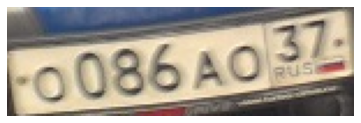

Rotated img:


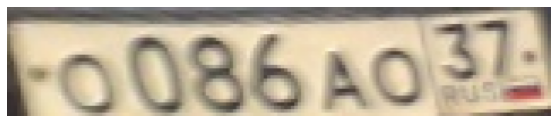

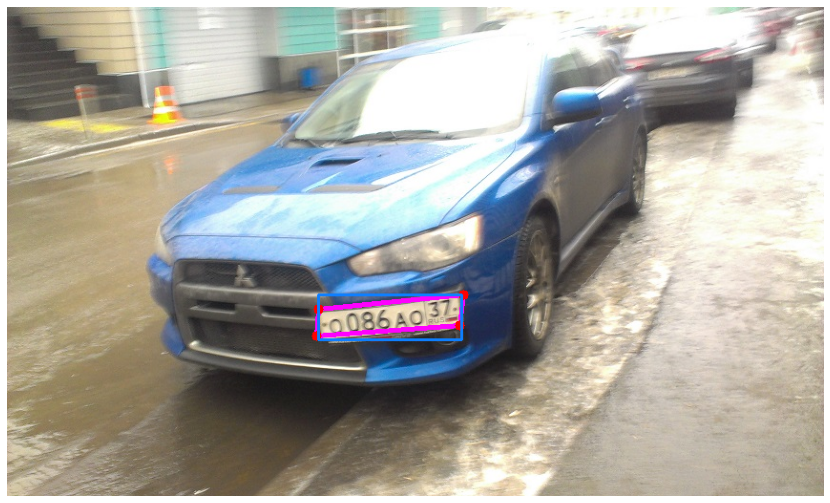

{'boxes': tensor([[326.6461, 302.5573, 476.4240, 349.2691]], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'scores': tensor([0.9999], device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}

In [71]:
visualize_prediction_plate(np.random.choice(test_images), model, id_to_name={1: 'plate'}, thresh=0.95)

### d) Предсказываем bounding box-ы и маску. 

- Маску превращаем в 4-угольный полигон. Сохраняем предсказания в json
- Если маска не приближается 4-угольником (редко такое бывает, бинарный поиск по гиперпараметру не работает), то просто записываем координаты bounding box 

In [72]:
model = get_detector_model()
model.load_state_dict(torch.load('detector_4epochs.pt'))
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequentia

In [73]:
THRESHOLD_SCORE = 0.93
TRESHOLD_MASK = 0.05

preds = []
model.eval()


for file in tqdm.tqdm(test_images, position=0, leave=False):

    img = Image.open(file).convert('RGB')
    img_tensor = my_transforms(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = file
    pred['nums'] = []

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()

        if score > THRESHOLD_SCORE:            
            # В разных версиях opencv этот метод возвращает разное число параметров
            contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
#             _,contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

            pred['nums'].append({
                'box': points,
                'bbox': [x_min, y_min, x_max, y_max],
            })

    preds.append(pred)   

    
with open(os.path.join(DATA_PATH, f'test_4epochs.json'), 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)

# 2. Распознаем номера

### a) Датасет для распознавания номеров

Из особенностей - на каждый номер мы генерируем bounding box + вырезаем по точкам и превращаем в прямоугольник наш 4-угольник по данным точкам. Т.е. 2 картинки на номер.

In [60]:
class OCRDataset(Dataset):
    def __init__(self, marks, img_folder, alphabet, transforms=None):
        ocr_marks = []
        for items in marks:
            file_path = items['file']
            for box in items['nums']:
                
                ocr_marks.append({
                    'file': file_path,
                    'box': np.clip(box['box'], 0, None).tolist(),
                    'text': box['text'],
                    'boxed': False,
                })
                            
                # Добавим точки, запакованные в BoundingBox. 
                # Вместо аугментации rotate. Датасет будет в 2 раза больше
                
                #Клипаем, ибо есть отрицательные координаты
                points = np.clip(box['box'], 0, None) 
                x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
                x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])

                ocr_marks.append({
                    'file': file_path,
                    'box': [x0, y0, x2, y2],
                    'text': box['text'],
                    'boxed': True,
                })
                
        self.marks = ocr_marks
        self.img_folder = img_folder
        self.transforms = transforms
        self.alphabet = alphabet
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = os.path.join(self.img_folder, item["file"])
        img = cv2.imread(img_path)

        if item['boxed']:
            x_min, y_min, x_max, y_max = item['box']
            img = img[y_min:y_max, x_min:x_max]
        else:
            points = np.clip(np.array(item['box']), 0, None)
            img = four_point_transform(img, points)
            
        text = item['text']
        seq = [self.alphabet.find(char) + 1 for char in text]
        seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)

        output = {
            'img': img,
            'text': text,
            'seq': seq,
            'seq_len': seq_len
        }
        
        return output
    
    
    def __len__(self):
        return len(self.marks)
    
    
class Resize(object):
    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, img):

        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img
    
my_ocr_transforms = transforms.Compose([
    Resize(size=(320, 64)),
    transforms.ToTensor()
])

def get_vocab_from_marks(marks):
    train_texts = []
    for item in marks:
        for num in item['nums']:
            train_texts.append(num['text'])

    counts = Counter(''.join(train_texts))
    alphabet = ''.join(set(''.join(train_texts)))
    corted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    char_to_idx = {item[0]: idx + 1 for idx, item in enumerate(corted_counts)}
    idx_to_char = {idx:char for char, idx in char_to_idx.items()}
    return char_to_idx, idx_to_char, alphabet

char_to_idx, idx_to_char, alphabet = get_vocab_from_marks(train_marks)

train_ocr_dataset = OCRDataset(
    marks=train_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)
# val_ocr_dataset = OCRDataset(
#     marks=val_marks, 
#     img_folder=DATA_PATH, 
#     alphabet=alphabet,
#     transforms=my_ocr_transforms
# )

def collate_fn_ocr(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Accepts list of dataset __get_item__ return values (dicts).
    Returns dict with same keys but values are either torch.Tensors of batched images, sequences, and so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        seqs.extend(sample["seq"])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

train_ocr_loader = DataLoader(
    train_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=True,
    num_workers=0, # Почему-то у меня виснет DataLoader, если запустить несколько потоков
    collate_fn=collate_fn_ocr,
    timeout=0,
    shuffle=True # Чтобы повернутые дубли картинок не шли подряд
)

# val_ocr_loader = DataLoader(
#     val_ocr_dataset, 
#     batch_size=BATCH_SIZE_OCR, 
#     drop_last=False,
#     num_workers=0,
#     collate_fn=collate_fn_ocr, 
#     timeout=0,
# )

gc.collect()

7

### b) Модель для распознования текста номера

In [61]:
class FeatureExtractor(nn.Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features
    
class SequencePredictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x
    
class CRNN(nn.Module):
    
    def __init__(
        self, 
        alphabet=alphabet,
        cnn_input_size=(64, 320), 
        cnn_output_len=20,
        rnn_hidden_size=128, 
        rnn_num_layers=2, 
        rnn_dropout=0.3, 
        rnn_bidirectional=False
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )
        
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=(len(alphabet) + 1), 
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

### c) Обучаем модель для распознавания текста номера

In [62]:
crnn = CRNN()
# crnn.load_state_dict(torch.load(OCR_MODEL_PATH))
crnn.to(device);

In [63]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)

In [64]:
crnn.train()
for epoch in range(2):
    epoch_losses = []
    print_loss = []
    
    for i, batch in enumerate(tqdm.tqdm(train_ocr_loader, total=len(train_ocr_loader), leave=False, position=0)):
        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = F.ctc_loss(
            log_probs=log_probs,  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt # N
        )  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print_loss.append(loss.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 
    
        epoch_losses.append(loss.item())

    print(i, np.mean(epoch_losses))

  1%|          | 20/3350 [00:05<16:24,  3.38it/s]

Loss: 5.4633089


  1%|          | 40/3350 [00:11<15:41,  3.51it/s]

Loss: 3.7470937


  2%|▏         | 60/3350 [00:17<16:30,  3.32it/s]

Loss: 3.4498040


  2%|▏         | 80/3350 [00:23<14:47,  3.68it/s]

Loss: 3.3362911


  3%|▎         | 100/3350 [00:29<16:46,  3.23it/s]

Loss: 3.2786366


  4%|▎         | 120/3350 [00:36<17:34,  3.06it/s]

Loss: 3.2471510


  4%|▍         | 140/3350 [00:42<16:21,  3.27it/s]

Loss: 3.1316863


  5%|▍         | 161/3350 [00:49<14:48,  3.59it/s]

Loss: 3.0538733


  5%|▌         | 180/3350 [00:55<18:34,  2.84it/s]

Loss: 2.9556651


  6%|▌         | 200/3350 [01:01<15:44,  3.34it/s]

Loss: 2.8842383


  7%|▋         | 220/3350 [01:07<15:02,  3.47it/s]

Loss: 2.8295529


  7%|▋         | 240/3350 [01:13<15:42,  3.30it/s]

Loss: 2.7952864


  8%|▊         | 260/3350 [01:18<16:29,  3.12it/s]

Loss: 2.7361992


  8%|▊         | 280/3350 [01:25<16:12,  3.16it/s]

Loss: 2.6975209


  9%|▉         | 300/3350 [01:31<17:04,  2.98it/s]

Loss: 2.6563340


 10%|▉         | 320/3350 [01:37<14:15,  3.54it/s]

Loss: 2.6285723


 10%|█         | 340/3350 [01:43<15:05,  3.32it/s]

Loss: 2.5678231


 11%|█         | 360/3350 [01:49<14:56,  3.34it/s]

Loss: 2.4898411


 11%|█▏        | 380/3350 [01:55<13:38,  3.63it/s]

Loss: 2.4341567


 12%|█▏        | 400/3350 [02:01<15:55,  3.09it/s]

Loss: 2.4233788


 13%|█▎        | 420/3350 [02:07<17:08,  2.85it/s]

Loss: 2.4019057


 13%|█▎        | 440/3350 [02:13<16:28,  2.94it/s]

Loss: 2.3321780


 14%|█▎        | 460/3350 [02:20<14:55,  3.23it/s]

Loss: 2.3093675


 14%|█▍        | 480/3350 [02:25<13:34,  3.52it/s]

Loss: 2.2588262


 15%|█▍        | 500/3350 [02:32<14:40,  3.24it/s]

Loss: 2.1711388


 16%|█▌        | 520/3350 [02:37<11:04,  4.26it/s]

Loss: 2.1277955


 16%|█▌        | 540/3350 [02:43<14:49,  3.16it/s]

Loss: 2.0147551


 17%|█▋        | 560/3350 [02:49<13:05,  3.55it/s]

Loss: 1.9502499


 17%|█▋        | 580/3350 [02:56<13:54,  3.32it/s]

Loss: 1.8614437


 18%|█▊        | 600/3350 [03:02<14:33,  3.15it/s]

Loss: 1.8285162


 19%|█▊        | 620/3350 [03:08<13:10,  3.45it/s]

Loss: 1.7402018


 19%|█▉        | 640/3350 [03:14<15:07,  2.99it/s]

Loss: 1.6494587


 20%|█▉        | 660/3350 [03:20<12:26,  3.60it/s]

Loss: 1.5671296


 20%|██        | 680/3350 [03:26<14:19,  3.11it/s]

Loss: 1.5046259


 21%|██        | 700/3350 [03:32<13:03,  3.38it/s]

Loss: 1.4063332


 21%|██▏       | 720/3350 [03:38<13:25,  3.26it/s]

Loss: 1.3320165


 22%|██▏       | 740/3350 [03:45<14:00,  3.10it/s]

Loss: 1.2742369


 23%|██▎       | 760/3350 [03:51<12:48,  3.37it/s]

Loss: 1.2228831


 23%|██▎       | 780/3350 [03:58<13:52,  3.09it/s]

Loss: 1.1722958


 24%|██▍       | 800/3350 [04:04<12:53,  3.29it/s]

Loss: 1.1269109


 24%|██▍       | 820/3350 [04:10<12:44,  3.31it/s]

Loss: 1.0284063


 25%|██▌       | 840/3350 [04:16<13:43,  3.05it/s]

Loss: 1.0159518


 26%|██▌       | 860/3350 [04:22<13:36,  3.05it/s]

Loss: 0.9145681


 26%|██▋       | 880/3350 [04:28<11:08,  3.70it/s]

Loss: 0.8785634


 27%|██▋       | 900/3350 [04:34<11:42,  3.49it/s]

Loss: 0.8617160


 27%|██▋       | 920/3350 [04:41<12:09,  3.33it/s]

Loss: 0.8334869


 28%|██▊       | 940/3350 [04:47<12:18,  3.26it/s]

Loss: 0.8151563


 29%|██▊       | 960/3350 [04:54<13:46,  2.89it/s]

Loss: 0.7455372


 29%|██▉       | 980/3350 [04:59<11:14,  3.51it/s]

Loss: 0.7214857


 30%|██▉       | 1000/3350 [05:06<12:04,  3.24it/s]

Loss: 0.6407770


 30%|███       | 1020/3350 [05:12<12:36,  3.08it/s]

Loss: 0.6370045


 31%|███       | 1040/3350 [05:19<12:47,  3.01it/s]

Loss: 0.5814163


 32%|███▏      | 1060/3350 [05:25<11:33,  3.30it/s]

Loss: 0.5693746


 32%|███▏      | 1080/3350 [05:31<11:46,  3.21it/s]

Loss: 0.5698537


 33%|███▎      | 1100/3350 [05:38<10:28,  3.58it/s]

Loss: 0.5467088


 33%|███▎      | 1120/3350 [05:44<13:30,  2.75it/s]

Loss: 0.5576226


 34%|███▍      | 1140/3350 [05:50<12:07,  3.04it/s]

Loss: 0.5416910


 35%|███▍      | 1160/3350 [05:56<12:04,  3.02it/s]

Loss: 0.5603854


 35%|███▌      | 1180/3350 [06:02<10:02,  3.60it/s]

Loss: 0.5382772


 36%|███▌      | 1201/3350 [06:09<09:57,  3.60it/s]

Loss: 0.4868531


 36%|███▋      | 1220/3350 [06:15<10:16,  3.46it/s]

Loss: 0.4827666


 37%|███▋      | 1240/3350 [06:21<10:38,  3.30it/s]

Loss: 0.4738944


 38%|███▊      | 1260/3350 [06:27<10:14,  3.40it/s]

Loss: 0.4235381


 38%|███▊      | 1280/3350 [06:33<10:47,  3.20it/s]

Loss: 0.4071241


 39%|███▉      | 1300/3350 [06:40<10:18,  3.32it/s]

Loss: 0.4372816


 39%|███▉      | 1320/3350 [06:46<10:37,  3.19it/s]

Loss: 0.4432394


 40%|████      | 1340/3350 [06:51<11:21,  2.95it/s]

Loss: 0.4249325


 41%|████      | 1360/3350 [06:58<11:10,  2.97it/s]

Loss: 0.4132798


 41%|████      | 1380/3350 [07:04<09:18,  3.53it/s]

Loss: 0.3243442


 42%|████▏     | 1400/3350 [07:10<09:09,  3.55it/s]

Loss: 0.3627854


 42%|████▏     | 1420/3350 [07:16<09:41,  3.32it/s]

Loss: 0.3640693


 43%|████▎     | 1440/3350 [07:23<09:21,  3.40it/s]

Loss: 0.3434796


 44%|████▎     | 1460/3350 [07:29<09:05,  3.46it/s]

Loss: 0.3220687


 44%|████▍     | 1480/3350 [07:35<08:54,  3.50it/s]

Loss: 0.2959220


 45%|████▍     | 1500/3350 [07:41<09:12,  3.35it/s]

Loss: 0.3018355


 45%|████▌     | 1520/3350 [07:47<08:57,  3.41it/s]

Loss: 0.3275716


 46%|████▌     | 1540/3350 [07:53<09:16,  3.25it/s]

Loss: 0.2962006


 47%|████▋     | 1560/3350 [07:59<08:52,  3.36it/s]

Loss: 0.2933119


 47%|████▋     | 1580/3350 [08:05<08:43,  3.38it/s]

Loss: 0.2729242


 48%|████▊     | 1600/3350 [08:11<08:28,  3.44it/s]

Loss: 0.2881608


 48%|████▊     | 1620/3350 [08:16<08:39,  3.33it/s]

Loss: 0.2893093


 49%|████▉     | 1640/3350 [08:22<08:52,  3.21it/s]

Loss: 0.3189968


 50%|████▉     | 1660/3350 [08:28<08:24,  3.35it/s]

Loss: 0.2424677


 50%|█████     | 1680/3350 [08:34<08:09,  3.41it/s]

Loss: 0.2576821


 51%|█████     | 1700/3350 [08:40<07:52,  3.49it/s]

Loss: 0.2574532


 51%|█████▏    | 1720/3350 [08:46<07:58,  3.41it/s]

Loss: 0.2213526


 52%|█████▏    | 1740/3350 [08:52<08:58,  2.99it/s]

Loss: 0.2399168


 53%|█████▎    | 1760/3350 [08:58<07:26,  3.56it/s]

Loss: 0.3009446


 53%|█████▎    | 1780/3350 [09:05<08:01,  3.26it/s]

Loss: 0.2645565


 54%|█████▎    | 1800/3350 [09:11<07:59,  3.23it/s]

Loss: 0.2894774


 54%|█████▍    | 1820/3350 [09:17<07:14,  3.53it/s]

Loss: 0.2657254


 55%|█████▍    | 1840/3350 [09:23<08:01,  3.14it/s]

Loss: 0.2685324


 56%|█████▌    | 1860/3350 [09:29<06:56,  3.58it/s]

Loss: 0.2353255


 56%|█████▌    | 1880/3350 [09:35<07:43,  3.17it/s]

Loss: 0.1837837


 57%|█████▋    | 1900/3350 [09:42<08:16,  2.92it/s]

Loss: 0.2365964


 57%|█████▋    | 1920/3350 [09:47<06:40,  3.57it/s]

Loss: 0.2318654


 58%|█████▊    | 1940/3350 [09:54<07:30,  3.13it/s]

Loss: 0.2436114


 59%|█████▊    | 1960/3350 [10:00<07:07,  3.25it/s]

Loss: 0.2183397


 59%|█████▉    | 1980/3350 [10:06<06:30,  3.51it/s]

Loss: 0.2477418


 60%|█████▉    | 2000/3350 [10:12<06:41,  3.36it/s]

Loss: 0.2527181


 60%|██████    | 2020/3350 [10:19<07:00,  3.17it/s]

Loss: 0.2565663


 61%|██████    | 2040/3350 [10:25<06:31,  3.35it/s]

Loss: 0.2858252


 61%|██████▏   | 2060/3350 [10:31<06:20,  3.39it/s]

Loss: 0.2401627


 62%|██████▏   | 2080/3350 [10:37<07:02,  3.00it/s]

Loss: 0.2508004


 63%|██████▎   | 2100/3350 [10:43<06:27,  3.23it/s]

Loss: 0.2693917
Epoch   105: reducing learning rate of group 0 to 1.5000e-04.


 63%|██████▎   | 2120/3350 [10:49<05:26,  3.77it/s]

Loss: 0.2280696


 64%|██████▍   | 2140/3350 [10:55<06:44,  2.99it/s]

Loss: 0.1765167


 64%|██████▍   | 2160/3350 [11:01<06:28,  3.07it/s]

Loss: 0.1835303


 65%|██████▌   | 2180/3350 [11:07<06:12,  3.14it/s]

Loss: 0.2458318


 66%|██████▌   | 2200/3350 [11:13<06:05,  3.15it/s]

Loss: 0.2167273


 66%|██████▋   | 2220/3350 [11:19<06:02,  3.12it/s]

Loss: 0.2073754


 67%|██████▋   | 2240/3350 [11:25<05:55,  3.12it/s]

Loss: 0.1945392


 67%|██████▋   | 2260/3350 [11:32<05:26,  3.34it/s]

Loss: 0.1751174


 68%|██████▊   | 2280/3350 [11:38<05:25,  3.29it/s]

Loss: 0.2018682


 69%|██████▊   | 2300/3350 [11:44<05:23,  3.25it/s]

Loss: 0.2071118


 69%|██████▉   | 2320/3350 [11:50<04:55,  3.49it/s]

Loss: 0.2005775


 70%|██████▉   | 2340/3350 [11:56<05:14,  3.21it/s]

Loss: 0.1927199


 70%|███████   | 2360/3350 [12:02<05:08,  3.21it/s]

Loss: 0.1985229


 71%|███████   | 2380/3350 [12:08<05:04,  3.19it/s]

Loss: 0.1540064


 72%|███████▏  | 2400/3350 [12:14<04:22,  3.61it/s]

Loss: 0.1957051


 72%|███████▏  | 2420/3350 [12:20<04:31,  3.42it/s]

Loss: 0.1846653


 73%|███████▎  | 2440/3350 [12:26<04:11,  3.62it/s]

Loss: 0.2122616


 73%|███████▎  | 2460/3350 [12:32<04:46,  3.11it/s]

Loss: 0.1512434


 74%|███████▍  | 2480/3350 [12:39<04:33,  3.18it/s]

Loss: 0.1619685


 75%|███████▍  | 2500/3350 [12:45<04:04,  3.48it/s]

Loss: 0.1442820


 75%|███████▌  | 2520/3350 [12:51<03:59,  3.47it/s]

Loss: 0.1998521


 76%|███████▌  | 2540/3350 [12:57<03:46,  3.57it/s]

Loss: 0.1846475


 76%|███████▋  | 2560/3350 [13:03<04:09,  3.17it/s]

Loss: 0.1780458


 77%|███████▋  | 2580/3350 [13:10<03:52,  3.31it/s]

Loss: 0.1834029


 78%|███████▊  | 2600/3350 [13:16<03:48,  3.28it/s]

Loss: 0.2226654


 78%|███████▊  | 2620/3350 [13:22<03:32,  3.44it/s]

Loss: 0.1550056


 79%|███████▉  | 2640/3350 [13:28<03:41,  3.21it/s]

Loss: 0.1876025


 79%|███████▉  | 2660/3350 [13:35<04:03,  2.84it/s]

Loss: 0.1774268


 80%|████████  | 2680/3350 [13:40<03:25,  3.26it/s]

Loss: 0.1394573


 81%|████████  | 2700/3350 [13:46<03:16,  3.32it/s]

Loss: 0.2114301


 81%|████████  | 2720/3350 [13:53<03:24,  3.07it/s]

Loss: 0.1917678


 82%|████████▏ | 2740/3350 [13:59<02:58,  3.42it/s]

Loss: 0.2184991


 82%|████████▏ | 2760/3350 [14:05<03:03,  3.22it/s]

Loss: 0.1554613


 83%|████████▎ | 2780/3350 [14:11<03:03,  3.10it/s]

Loss: 0.2013507


 84%|████████▎ | 2800/3350 [14:18<02:59,  3.06it/s]

Loss: 0.1505984


 84%|████████▍ | 2820/3350 [14:24<02:41,  3.28it/s]

Loss: 0.1926980


 85%|████████▍ | 2840/3350 [14:30<02:39,  3.19it/s]

Loss: 0.1807082


 85%|████████▌ | 2860/3350 [14:36<02:46,  2.95it/s]

Loss: 0.1827573


 86%|████████▌ | 2880/3350 [14:43<02:26,  3.22it/s]

Loss: 0.1874802


 87%|████████▋ | 2900/3350 [14:49<02:37,  2.85it/s]

Loss: 0.1588098
Epoch   145: reducing learning rate of group 0 to 7.5000e-05.


 87%|████████▋ | 2920/3350 [14:56<02:14,  3.19it/s]

Loss: 0.1534116


 88%|████████▊ | 2940/3350 [15:02<02:00,  3.42it/s]

Loss: 0.1758464


 88%|████████▊ | 2960/3350 [15:08<01:56,  3.34it/s]

Loss: 0.1892674


 89%|████████▉ | 2980/3350 [15:14<01:52,  3.28it/s]

Loss: 0.1882484


 90%|████████▉ | 3000/3350 [15:20<01:43,  3.38it/s]

Loss: 0.1849982


 90%|█████████ | 3020/3350 [15:26<01:35,  3.47it/s]

Loss: 0.1826121


 91%|█████████ | 3040/3350 [15:32<01:36,  3.21it/s]

Loss: 0.1190888


 91%|█████████▏| 3060/3350 [15:38<01:27,  3.31it/s]

Loss: 0.1460272


 92%|█████████▏| 3080/3350 [15:44<01:24,  3.20it/s]

Loss: 0.1529245


 93%|█████████▎| 3100/3350 [15:50<01:12,  3.46it/s]

Loss: 0.1798055


 93%|█████████▎| 3120/3350 [15:56<01:05,  3.49it/s]

Loss: 0.1479674


 94%|█████████▎| 3140/3350 [16:02<01:06,  3.15it/s]

Loss: 0.1432112


 94%|█████████▍| 3160/3350 [16:09<01:02,  3.04it/s]

Loss: 0.1653713


 95%|█████████▍| 3180/3350 [16:15<00:54,  3.10it/s]

Loss: 0.1455912


 96%|█████████▌| 3200/3350 [16:22<00:41,  3.59it/s]

Loss: 0.1642346


 96%|█████████▌| 3220/3350 [16:28<00:38,  3.37it/s]

Loss: 0.1767676


 97%|█████████▋| 3240/3350 [16:34<00:37,  2.94it/s]

Loss: 0.1510523


 97%|█████████▋| 3260/3350 [16:40<00:30,  2.90it/s]

Loss: 0.1606650
Epoch   163: reducing learning rate of group 0 to 3.7500e-05.


 98%|█████████▊| 3280/3350 [16:46<00:22,  3.11it/s]

Loss: 0.1308482


 99%|█████████▊| 3300/3350 [16:52<00:13,  3.78it/s]

Loss: 0.1559448


 99%|█████████▉| 3320/3350 [16:58<00:08,  3.59it/s]

Loss: 0.1377809


100%|█████████▉| 3340/3350 [17:04<00:03,  3.20it/s]

Loss: 0.1443969


  0%|          | 0/3350 [00:00<?, ?it/s]           

3349 0.805025720412829


  1%|          | 20/3350 [00:06<17:38,  3.15it/s]

Loss: 0.1528936


  1%|          | 40/3350 [00:12<15:53,  3.47it/s]

Loss: 0.1353235


  2%|▏         | 60/3350 [00:18<16:54,  3.24it/s]

Loss: 0.1791145


  2%|▏         | 80/3350 [00:24<17:25,  3.13it/s]

Loss: 0.1235220


  3%|▎         | 100/3350 [00:30<17:15,  3.14it/s]

Loss: 0.1512645


  4%|▎         | 120/3350 [00:36<15:27,  3.48it/s]

Loss: 0.1761786


  4%|▍         | 140/3350 [00:42<14:42,  3.64it/s]

Loss: 0.0990917


  5%|▍         | 160/3350 [00:49<14:07,  3.76it/s]

Loss: 0.1662675


  5%|▌         | 180/3350 [00:55<14:25,  3.66it/s]

Loss: 0.1315239


  6%|▌         | 200/3350 [01:01<16:01,  3.28it/s]

Loss: 0.1651022


  7%|▋         | 220/3350 [01:07<15:05,  3.46it/s]

Loss: 0.1140702


  7%|▋         | 240/3350 [01:13<16:51,  3.08it/s]

Loss: 0.1295020


  8%|▊         | 260/3350 [01:19<16:07,  3.19it/s]

Loss: 0.1295005


  8%|▊         | 280/3350 [01:25<14:50,  3.45it/s]

Loss: 0.1352300


  9%|▉         | 300/3350 [01:32<16:35,  3.06it/s]

Loss: 0.1315167


 10%|▉         | 320/3350 [01:38<15:36,  3.24it/s]

Loss: 0.1448825


 10%|█         | 340/3350 [01:43<15:04,  3.33it/s]

Loss: 0.1519233


 11%|█         | 360/3350 [01:49<13:54,  3.58it/s]

Loss: 0.1525980
Epoch   185: reducing learning rate of group 0 to 1.8750e-05.


 11%|█▏        | 380/3350 [01:56<12:48,  3.86it/s]

Loss: 0.1160222


 12%|█▏        | 400/3350 [02:02<14:36,  3.37it/s]

Loss: 0.1396054


 13%|█▎        | 420/3350 [02:08<14:38,  3.33it/s]

Loss: 0.1663610


 13%|█▎        | 440/3350 [02:14<12:48,  3.79it/s]

Loss: 0.1298921


 14%|█▎        | 460/3350 [02:20<16:24,  2.93it/s]

Loss: 0.1508055


 14%|█▍        | 480/3350 [02:26<15:01,  3.18it/s]

Loss: 0.1669176


 15%|█▍        | 500/3350 [02:33<13:33,  3.50it/s]

Loss: 0.1323799


 16%|█▌        | 520/3350 [02:39<12:42,  3.71it/s]

Loss: 0.1388344


 16%|█▌        | 540/3350 [02:45<15:17,  3.06it/s]

Loss: 0.1215658


 17%|█▋        | 560/3350 [02:51<13:41,  3.40it/s]

Loss: 0.1880716


 17%|█▋        | 580/3350 [02:57<13:57,  3.31it/s]

Loss: 0.1193201
Epoch   196: reducing learning rate of group 0 to 9.3750e-06.


 18%|█▊        | 600/3350 [03:03<14:46,  3.10it/s]

Loss: 0.1348368


 19%|█▊        | 620/3350 [03:09<13:56,  3.26it/s]

Loss: 0.1345553


 19%|█▉        | 640/3350 [03:15<13:22,  3.38it/s]

Loss: 0.1597195


 20%|█▉        | 660/3350 [03:21<12:15,  3.66it/s]

Loss: 0.1493797


 20%|██        | 680/3350 [03:27<14:45,  3.02it/s]

Loss: 0.1353011


 21%|██        | 700/3350 [03:33<13:13,  3.34it/s]

Loss: 0.1638827


 21%|██▏       | 720/3350 [03:40<13:45,  3.18it/s]

Loss: 0.1301585


 22%|██▏       | 740/3350 [03:46<12:06,  3.59it/s]

Loss: 0.1247456


 23%|██▎       | 760/3350 [03:53<13:50,  3.12it/s]

Loss: 0.1259785


 23%|██▎       | 780/3350 [03:59<13:49,  3.10it/s]

Loss: 0.1017283


 24%|██▍       | 800/3350 [04:05<11:52,  3.58it/s]

Loss: 0.1009116
Epoch   207: reducing learning rate of group 0 to 4.6875e-06.


 24%|██▍       | 820/3350 [04:11<12:15,  3.44it/s]

Loss: 0.1030311


 25%|██▌       | 840/3350 [04:17<11:50,  3.53it/s]

Loss: 0.1378363


 26%|██▌       | 860/3350 [04:23<12:48,  3.24it/s]

Loss: 0.1437076


 26%|██▋       | 880/3350 [04:29<13:21,  3.08it/s]

Loss: 0.1426826


 27%|██▋       | 900/3350 [04:35<11:17,  3.62it/s]

Loss: 0.1243539


 27%|██▋       | 920/3350 [04:41<12:21,  3.28it/s]

Loss: 0.1612256


 28%|██▊       | 940/3350 [04:48<12:25,  3.23it/s]

Loss: 0.1703002


 29%|██▊       | 960/3350 [04:54<12:26,  3.20it/s]

Loss: 0.1362009


 29%|██▉       | 980/3350 [05:00<11:25,  3.46it/s]

Loss: 0.1256125


 30%|██▉       | 1000/3350 [05:06<12:44,  3.07it/s]

Loss: 0.1224332


 30%|███       | 1020/3350 [05:13<13:22,  2.90it/s]

Loss: 0.1708020
Epoch   218: reducing learning rate of group 0 to 2.3437e-06.


 31%|███       | 1040/3350 [05:19<12:04,  3.19it/s]

Loss: 0.1007422


 32%|███▏      | 1060/3350 [05:25<11:51,  3.22it/s]

Loss: 0.1439497


 32%|███▏      | 1080/3350 [05:31<10:27,  3.62it/s]

Loss: 0.1495636


 33%|███▎      | 1100/3350 [05:38<12:06,  3.10it/s]

Loss: 0.1312766


 33%|███▎      | 1120/3350 [05:44<11:44,  3.16it/s]

Loss: 0.1188314


 34%|███▍      | 1140/3350 [05:50<11:43,  3.14it/s]

Loss: 0.1176849


 35%|███▍      | 1160/3350 [05:56<10:38,  3.43it/s]

Loss: 0.1524602


 35%|███▌      | 1180/3350 [06:02<09:44,  3.71it/s]

Loss: 0.1254573


 36%|███▌      | 1200/3350 [06:08<10:16,  3.49it/s]

Loss: 0.1253835


 36%|███▋      | 1220/3350 [06:15<10:43,  3.31it/s]

Loss: 0.1388737


 37%|███▋      | 1240/3350 [06:21<11:29,  3.06it/s]

Loss: 0.1440852
Epoch   229: reducing learning rate of group 0 to 1.1719e-06.


 38%|███▊      | 1260/3350 [06:27<10:25,  3.34it/s]

Loss: 0.1249095


 38%|███▊      | 1280/3350 [06:33<10:03,  3.43it/s]

Loss: 0.1410710


 39%|███▉      | 1300/3350 [06:39<09:43,  3.51it/s]

Loss: 0.1464002


 39%|███▉      | 1320/3350 [06:45<11:16,  3.00it/s]

Loss: 0.1447186


 40%|████      | 1340/3350 [06:51<09:15,  3.62it/s]

Loss: 0.1272759


 41%|████      | 1360/3350 [06:57<12:00,  2.76it/s]

Loss: 0.1322431


 41%|████      | 1380/3350 [07:04<10:02,  3.27it/s]

Loss: 0.1602252


 42%|████▏     | 1400/3350 [07:10<09:08,  3.55it/s]

Loss: 0.1361819


 42%|████▏     | 1420/3350 [07:17<09:38,  3.34it/s]

Loss: 0.1314279


 43%|████▎     | 1440/3350 [07:23<09:40,  3.29it/s]

Loss: 0.1162966


 44%|████▎     | 1460/3350 [07:29<09:01,  3.49it/s]

Loss: 0.1231005
Epoch   240: reducing learning rate of group 0 to 5.8594e-07.


 44%|████▍     | 1480/3350 [07:35<10:01,  3.11it/s]

Loss: 0.1444943


 45%|████▍     | 1500/3350 [07:42<09:56,  3.10it/s]

Loss: 0.0946381


 45%|████▌     | 1520/3350 [07:48<09:08,  3.34it/s]

Loss: 0.1220090


 46%|████▌     | 1540/3350 [07:54<10:01,  3.01it/s]

Loss: 0.1566535


 47%|████▋     | 1560/3350 [08:01<09:54,  3.01it/s]

Loss: 0.1394507


 47%|████▋     | 1580/3350 [08:07<08:29,  3.47it/s]

Loss: 0.1628664


 48%|████▊     | 1600/3350 [08:13<09:12,  3.17it/s]

Loss: 0.1638761


 48%|████▊     | 1620/3350 [08:19<08:07,  3.55it/s]

Loss: 0.1166309


 49%|████▉     | 1640/3350 [08:25<09:16,  3.07it/s]

Loss: 0.2023811


 50%|████▉     | 1660/3350 [08:31<08:18,  3.39it/s]

Loss: 0.1196383


 50%|█████     | 1680/3350 [08:37<08:05,  3.44it/s]

Loss: 0.1511754


 51%|█████     | 1700/3350 [08:43<09:06,  3.02it/s]

Loss: 0.1281242


 51%|█████▏    | 1720/3350 [08:49<08:51,  3.07it/s]

Loss: 0.1359057
Epoch   253: reducing learning rate of group 0 to 2.9297e-07.


 52%|█████▏    | 1740/3350 [08:55<08:21,  3.21it/s]

Loss: 0.1635381


 53%|█████▎    | 1760/3350 [09:02<08:10,  3.24it/s]

Loss: 0.1156915


 53%|█████▎    | 1780/3350 [09:08<08:00,  3.27it/s]

Loss: 0.1414482


 54%|█████▎    | 1800/3350 [09:14<09:00,  2.87it/s]

Loss: 0.1593531


 54%|█████▍    | 1820/3350 [09:21<09:19,  2.74it/s]

Loss: 0.1242692


 55%|█████▍    | 1840/3350 [09:27<08:05,  3.11it/s]

Loss: 0.1303759


 56%|█████▌    | 1860/3350 [09:33<08:02,  3.09it/s]

Loss: 0.1237550


 56%|█████▌    | 1880/3350 [09:40<07:41,  3.19it/s]

Loss: 0.1283621


 57%|█████▋    | 1900/3350 [09:46<06:53,  3.51it/s]

Loss: 0.1318648


 57%|█████▋    | 1920/3350 [09:52<07:45,  3.07it/s]

Loss: 0.1185613


 58%|█████▊    | 1940/3350 [09:58<07:39,  3.07it/s]

Loss: 0.1367796
Epoch   264: reducing learning rate of group 0 to 1.4648e-07.


 59%|█████▊    | 1960/3350 [10:04<07:36,  3.04it/s]

Loss: 0.1495002


 59%|█████▉    | 1980/3350 [10:10<07:08,  3.20it/s]

Loss: 0.1394382


 60%|█████▉    | 2000/3350 [10:16<06:49,  3.30it/s]

Loss: 0.1567056


 60%|██████    | 2020/3350 [10:22<06:08,  3.61it/s]

Loss: 0.1754156


 61%|██████    | 2040/3350 [10:28<07:32,  2.89it/s]

Loss: 0.1542531


 61%|██████▏   | 2060/3350 [10:34<05:53,  3.64it/s]

Loss: 0.1547199


 62%|██████▏   | 2080/3350 [10:40<06:10,  3.43it/s]

Loss: 0.1611557


 63%|██████▎   | 2100/3350 [10:46<05:21,  3.89it/s]

Loss: 0.1440480


 63%|██████▎   | 2120/3350 [10:52<06:18,  3.25it/s]

Loss: 0.1755470


 64%|██████▍   | 2140/3350 [10:58<06:10,  3.26it/s]

Loss: 0.1606548


 64%|██████▍   | 2160/3350 [11:04<06:11,  3.21it/s]

Loss: 0.1269239
Epoch   275: reducing learning rate of group 0 to 7.3242e-08.


 65%|██████▌   | 2180/3350 [11:10<05:23,  3.62it/s]

Loss: 0.1511901


 66%|██████▌   | 2200/3350 [11:16<06:27,  2.97it/s]

Loss: 0.1567400


 66%|██████▋   | 2220/3350 [11:22<06:11,  3.04it/s]

Loss: 0.1645912


 67%|██████▋   | 2240/3350 [11:29<05:39,  3.27it/s]

Loss: 0.1484034


 67%|██████▋   | 2260/3350 [11:35<05:15,  3.45it/s]

Loss: 0.1429694


 68%|██████▊   | 2280/3350 [11:41<05:31,  3.22it/s]

Loss: 0.1416105


 69%|██████▊   | 2300/3350 [11:47<04:48,  3.64it/s]

Loss: 0.1183869


 69%|██████▉   | 2320/3350 [11:53<04:54,  3.50it/s]

Loss: 0.1037309


 70%|██████▉   | 2340/3350 [12:00<05:39,  2.98it/s]

Loss: 0.1306939


 70%|███████   | 2360/3350 [12:06<04:34,  3.61it/s]

Loss: 0.1430095


 71%|███████   | 2380/3350 [12:12<04:34,  3.54it/s]

Loss: 0.1263069
Epoch   286: reducing learning rate of group 0 to 3.6621e-08.


 72%|███████▏  | 2400/3350 [12:18<05:23,  2.94it/s]

Loss: 0.1590864


 72%|███████▏  | 2420/3350 [12:23<04:28,  3.46it/s]

Loss: 0.1218704


 73%|███████▎  | 2440/3350 [12:30<04:53,  3.10it/s]

Loss: 0.1648489


 73%|███████▎  | 2460/3350 [12:36<04:05,  3.62it/s]

Loss: 0.1148573


 74%|███████▍  | 2480/3350 [12:41<04:30,  3.22it/s]

Loss: 0.1310954


 75%|███████▍  | 2500/3350 [12:47<04:26,  3.18it/s]

Loss: 0.1252029


 75%|███████▌  | 2520/3350 [12:53<03:55,  3.53it/s]

Loss: 0.1082873


 76%|███████▌  | 2540/3350 [13:00<04:41,  2.88it/s]

Loss: 0.1269480


 76%|███████▋  | 2560/3350 [13:06<04:07,  3.20it/s]

Loss: 0.1144352


 77%|███████▋  | 2580/3350 [13:12<03:54,  3.28it/s]

Loss: 0.1230703


 78%|███████▊  | 2600/3350 [13:18<03:47,  3.30it/s]

Loss: 0.1504125
Epoch   297: reducing learning rate of group 0 to 1.8311e-08.


 78%|███████▊  | 2620/3350 [13:25<04:39,  2.61it/s]

Loss: 0.1171332


 79%|███████▉  | 2640/3350 [13:32<03:31,  3.36it/s]

Loss: 0.1544019


 79%|███████▉  | 2660/3350 [13:38<03:19,  3.46it/s]

Loss: 0.1765844


 80%|████████  | 2680/3350 [13:44<04:02,  2.76it/s]

Loss: 0.1467410


 81%|████████  | 2700/3350 [13:50<03:11,  3.39it/s]

Loss: 0.1326908


 81%|████████  | 2720/3350 [13:56<03:02,  3.45it/s]

Loss: 0.1496812


 82%|████████▏ | 2740/3350 [14:02<03:04,  3.30it/s]

Loss: 0.1370186


 82%|████████▏ | 2760/3350 [14:08<02:35,  3.78it/s]

Loss: 0.1280749


 83%|████████▎ | 2780/3350 [14:14<02:51,  3.32it/s]

Loss: 0.1315968


 84%|████████▎ | 2800/3350 [14:20<02:38,  3.47it/s]

Loss: 0.1446663


 84%|████████▍ | 2820/3350 [14:26<02:32,  3.48it/s]

Loss: 0.0992450


 85%|████████▍ | 2840/3350 [14:32<02:26,  3.49it/s]

Loss: 0.1316131


 85%|████████▌ | 2860/3350 [14:39<03:02,  2.68it/s]

Loss: 0.1195720


 86%|████████▌ | 2880/3350 [14:45<02:24,  3.24it/s]

Loss: 0.1251503


 87%|████████▋ | 2900/3350 [14:50<02:17,  3.28it/s]

Loss: 0.1457177


 87%|████████▋ | 2920/3350 [14:57<02:28,  2.89it/s]

Loss: 0.1275169


 88%|████████▊ | 2940/3350 [15:03<02:16,  3.01it/s]

Loss: 0.1048443


 88%|████████▊ | 2960/3350 [15:09<01:59,  3.27it/s]

Loss: 0.1287874


 89%|████████▉ | 2980/3350 [15:15<01:54,  3.22it/s]

Loss: 0.1364325


 90%|████████▉ | 3000/3350 [15:21<01:47,  3.24it/s]

Loss: 0.1331781


 90%|█████████ | 3020/3350 [15:28<01:50,  2.97it/s]

Loss: 0.1168531


 91%|█████████ | 3040/3350 [15:34<01:38,  3.14it/s]

Loss: 0.1447637


 91%|█████████▏| 3060/3350 [15:40<01:36,  2.99it/s]

Loss: 0.1302859


 92%|█████████▏| 3080/3350 [15:47<01:27,  3.07it/s]

Loss: 0.1960002


 93%|█████████▎| 3100/3350 [15:53<01:14,  3.35it/s]

Loss: 0.1252961


 93%|█████████▎| 3120/3350 [15:59<01:08,  3.34it/s]

Loss: 0.1639133


 94%|█████████▎| 3140/3350 [16:05<01:08,  3.07it/s]

Loss: 0.1119693


 94%|█████████▍| 3160/3350 [16:11<01:03,  3.00it/s]

Loss: 0.1371092


 95%|█████████▍| 3180/3350 [16:18<00:46,  3.66it/s]

Loss: 0.1230266


 96%|█████████▌| 3200/3350 [16:24<00:49,  3.04it/s]

Loss: 0.1204392


 96%|█████████▌| 3220/3350 [16:30<00:49,  2.64it/s]

Loss: 0.1333887


 97%|█████████▋| 3240/3350 [16:36<00:30,  3.60it/s]

Loss: 0.1288506


 97%|█████████▋| 3260/3350 [16:42<00:26,  3.36it/s]

Loss: 0.1486355


 98%|█████████▊| 3280/3350 [16:49<00:22,  3.16it/s]

Loss: 0.1415189


 99%|█████████▊| 3300/3350 [16:55<00:16,  3.12it/s]

Loss: 0.1397788


 99%|█████████▉| 3320/3350 [17:00<00:08,  3.74it/s]

Loss: 0.1721047


100%|█████████▉| 3340/3350 [17:06<00:03,  3.33it/s]

Loss: 0.2084607


3349 0.1387049013465198


In [66]:
torch.save(crnn.state_dict(), OCR_MODEL_PATH)

### d) Наконец, делаем предсказания

In [74]:
test_marks = load_json(os.path.join(DATA_PATH, 'test_4epochs.json'))
crnn.eval()
resizer = Resize()

file_name_result = [] 
plates_string_result = []

for item in tqdm.tqdm(test_marks, leave=False, position=0):

    img_path = item["file"]
    img = cv2.imread(img_path)

    results_to_sort = []
    for box in item['nums']:
        x_min, y_min, x_max, y_max = box['bbox']
        img_bbox = resizer(img[y_min:y_max, x_min:x_max])
        img_bbox = my_transforms(img_bbox)
        img_bbox = img_bbox.unsqueeze(0)


        points = np.clip(np.array(box['box']), 0, None)
        img_polygon = resizer(four_point_transform(img, points))
        img_polygon = my_transforms(img_polygon)
        img_polygon = img_polygon.unsqueeze(0)

        preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
        preds_poly = crnn(img_polygon.to(device)).cpu().detach()

        preds = preds_poly + preds_bbox
        num_text = decode(preds, alphabet)[0]

        results_to_sort.append((x_min, num_text))

    results = sorted(results_to_sort, key=lambda x: x[0])
    num_list = [x[1] for x in results]

    plates_string = ' '.join(num_list)
    file_name = img_path[img_path.find('test/'):]

    file_name_result.append(file_name)
    plates_string_result.append(plates_string)
    
df_submit = pd.DataFrame({'file_name': file_name_result, 'plates_string': plates_string_result})
df_submit.to_csv('submission6.csv', index=False)